In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid
from GRF_perturbations.Modules.GRF_generation import get_k_grid

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


ImportError: cannot import name 'Radial_profile' from 'GRF_perturbations.Modules.Image_processing' (/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Image_processing.py)

# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Grid

In [4]:
grid_size=128

logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

node_num=2

In [5]:
def coordinates(node_num,batch):
    logA_batch=logA_array[node_num*32:(node_num+1)*32]
    Beta_batch=Beta_array[batch:batch+16]
    return logA_batch,Beta_batch

In [6]:
!ls ../Processing_scripts/results/Anomalies

anomalies_grid_node_2_batch_0.npz  anomalies_grid_node_2_batch_48.npz
anomalies_grid_node_2_batch_16.npz anomalies_grid_node_2_batch_64.npz
anomalies_grid_node_2_batch_32.npz anomalies_grid_node_2_batch_80.npz


In [7]:
Grid_batch32=np.load('../Processing_scripts/results/Anomalies/anomalies_grid_node_{:.0f}_batch_{:.0f}.npz'.format(node_num,32))['arr_0']

In [8]:
Grid_batch80=np.load('../Processing_scripts/results/Anomalies/anomalies_grid_node_{:.0f}_batch_{:.0f}.npz'.format(node_num,80))['arr_0']

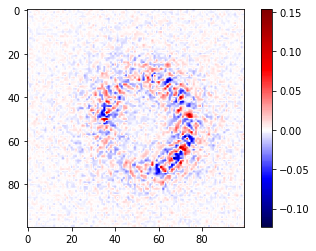

In [8]:
plt.imshow(Grid_batch32[-1,0,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

In [9]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

In [10]:
q=Grid_batch32.mean(axis=(2))

In [11]:
p=(q/np.abs(Image_unperturbed_noiseless))*Observation_conditions.annulus_mask

In [12]:
p.shape

(32, 16, 100, 100)

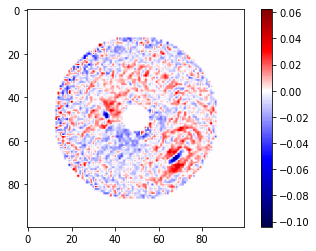

In [13]:
plt.imshow(p[-1,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

In [15]:
p.max()

0.10178139181507805

In [16]:
p.min()

-0.10390153547583439

In [18]:
Vars=Grid_batch32.std(axis=(2))**2

In [23]:
p=np.sqrt((Vars/np.power(Image_unperturbed_noiseless,2)))*Observation_conditions.annulus_mask

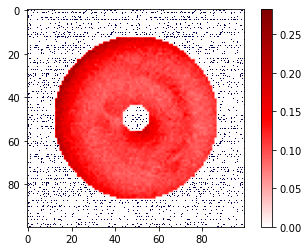

In [24]:
plt.imshow(p[-1,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

In [25]:
p.max()

0.3055480676645575

In [26]:
l=np.sort(p[-1,0].flatten())

In [27]:
np.unique(l)

array([0.        , 0.06999746, 0.0714351 , ..., 0.2661967 , 0.27472775,
       0.28255539])

In [11]:
spectra=np.abs(np.fft.fft2(Grid_batch80*Observation_conditions.annulus_mask))**2
#Due to masking high scales are absent
#spectra=spectra[:,:,:,13:-13,:50]

In [15]:
k_vector=np.fft.fftfreq(100,0.08)

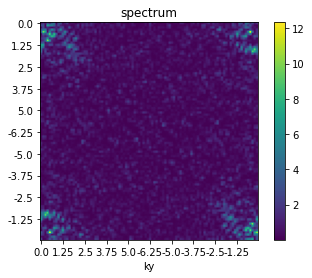

In [18]:
plt.imshow(spectra[-1,10,0])
plt.xticks(np.arange(0,100,10),k_vector[::10])
plt.xlabel('kx')
#q=k_vector[13:-13]
plt.yticks(np.arange(0,100,10),k_vector[::10])
plt.xlabel('ky')
plt.title('spectrum')
plt.colorbar()

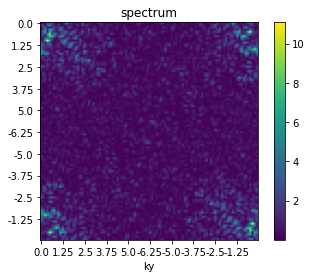

In [23]:
plt.imshow(spectra[-1,0,0])
plt.xticks(np.arange(0,100,10),k_vector[::10])
plt.xlabel('kx')
#q=k_vector[13:-13]
plt.yticks(np.arange(0,100,10),k_vector[::10])
plt.xlabel('ky')
plt.title('spectrum')
plt.colorbar()

In [42]:
Gamma_scales=spectra.mean(axis=2)
Spectral_dof=2*np.ones_like(spectr[0,0,0])
Spectral_dof[0,0]=1
Spectral_dof[0,50]=1
Spectral_dof[50,0]=1
Spectral_dof[50,50]=1

Text(0, 0.5, 'Number density')

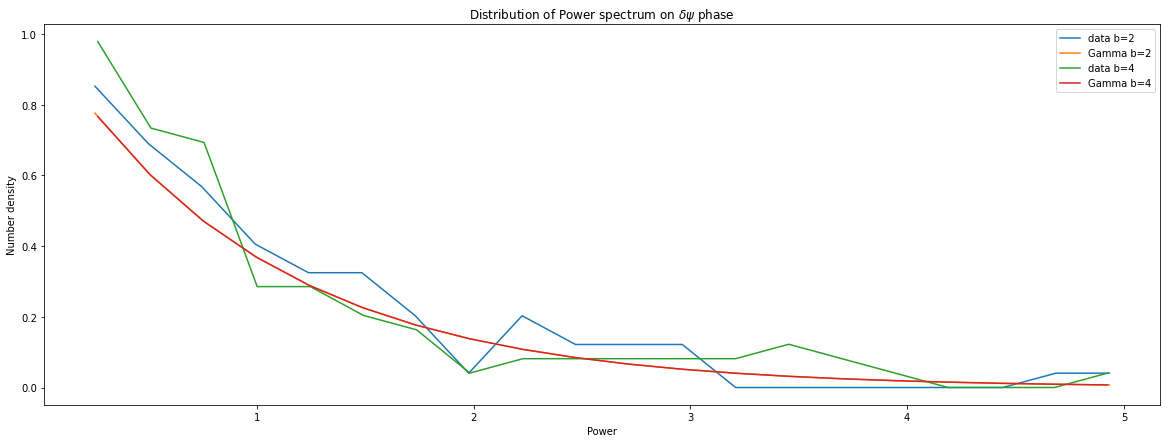

In [45]:
import scipy as sc
i=50
j=20

A_index0=21
B_index0=10

A_index1=11
B_index1=5

data0,x0=np.histogram(spectra[A_index0,B_index0,:,i,j]/Gamma_scales[A_index0,B_index0,i,j],bins=20,density=True)
data1,x1=np.histogram(spectra[A_index1,B_index1,:,i,j]/Gamma_scales[A_index1,B_index1,i,j],bins=20,density=True)

m=sc.stats.gamma.pdf(x0[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)
l=sc.stats.gamma.pdf(x1[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)

plt.figure(figsize=(20,7))

plt.plot(x0[1:],data0/sc.special.gamma(Spectral_dof[i,j]/2),label='data b=2')
plt.plot(x0[1:],m,label='Gamma b=2')
plt.plot(x1[1:],data1/sc.special.gamma(Spectral_dof[i,j]/2),label='data b=4')
plt.plot(x1[1:],l,label='Gamma b=4')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

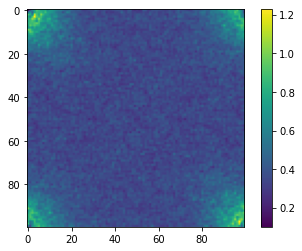

In [46]:
plt.imshow(Gamma_scales[0,0])
plt.colorbar()

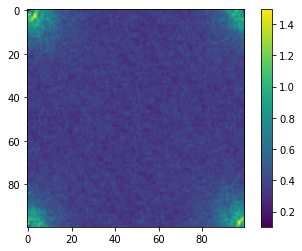

In [48]:
plt.imshow(Gamma_scales[0,-1])
plt.colorbar()

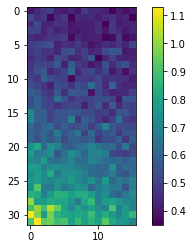

In [52]:
plt.imshow(Gamma_scales[:,:,10,20])
plt.colorbar()

Text(0, 0.5, 'Number density')

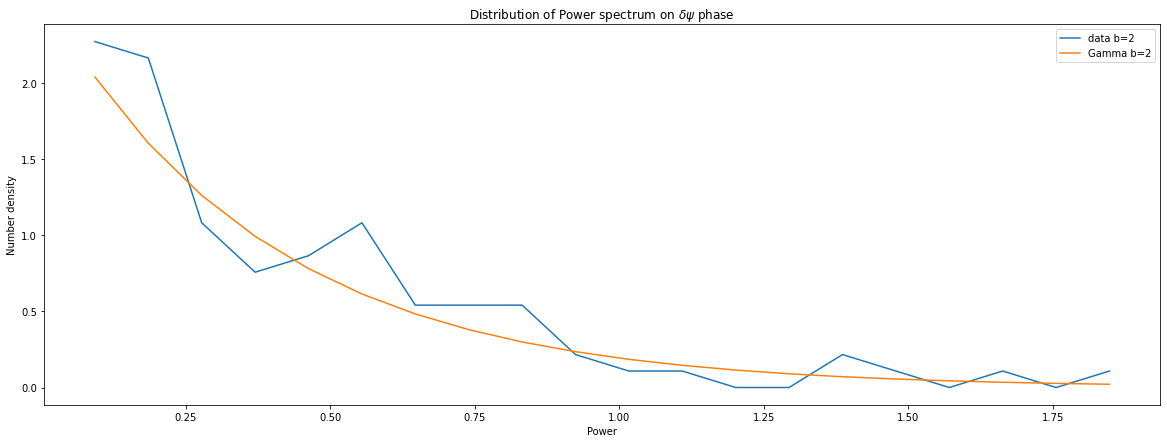

In [53]:
import scipy as sc
A_index=0
B_index=10

i=10
j=30

data,x=np.histogram(spectra[A_index,B_index,:,i,j],bins=20,density=True)


m=sc.stats.gamma.pdf(x[1:],a=1,loc=0,scale=Gamma_scales[A_index,B_index,i,j])

plt.figure(figsize=(20,7))

plt.plot(x[1:],data,label='data b=2')
plt.plot(x[1:],m,label='Gamma b=2')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

Text(0, 0.5, 'Number density')

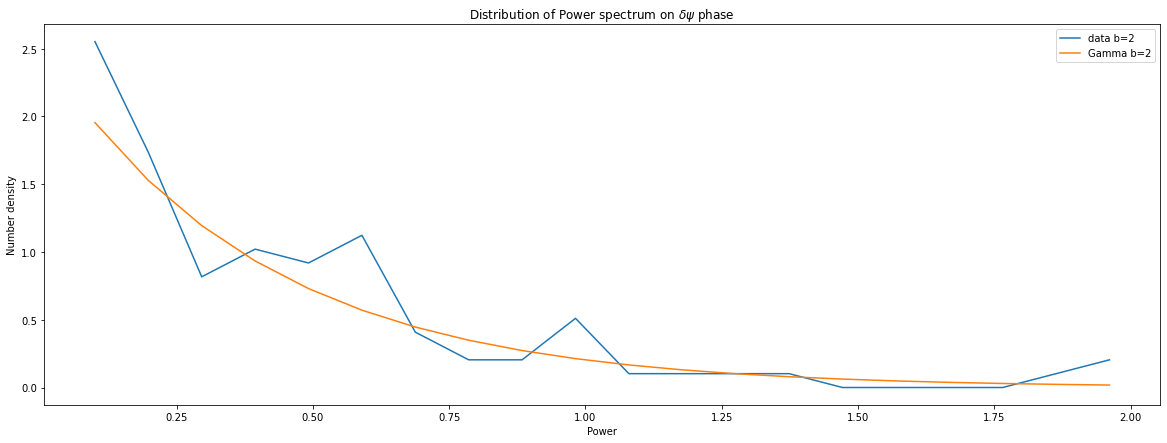

In [54]:
import scipy as sc
A_index=21
B_index=10

i=10
j=30

data,x=np.histogram(spectra[A_index,B_index,:,i,j],bins=20,density=True)


m=sc.stats.gamma.pdf(x[1:],a=1,loc=0,scale=Gamma_scales[A_index,B_index,i,j])

plt.figure(figsize=(20,7))

plt.plot(x[1:],data,label='data b=2')
plt.plot(x[1:],m,label='Gamma b=2')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

Text(0, 0.5, 'Number density')

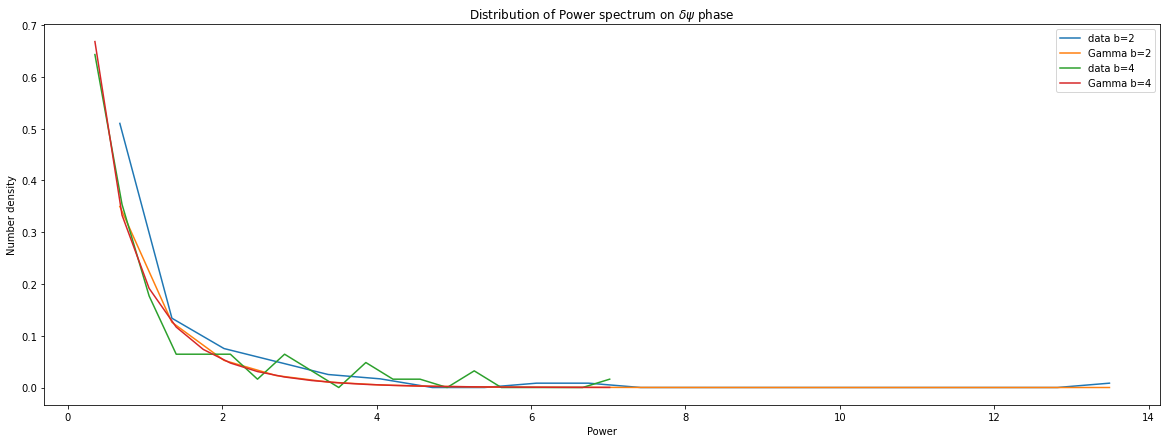

In [55]:
i=50
j=0

A_index0=21
B_index0=10

A_index1=11
B_index1=5

data0,x0=np.histogram(spectra[A_index0,B_index0,:,i,j]/Gamma_scales[A_index0,B_index0,i,j],bins=20,density=True)
data1,x1=np.histogram(spectra[A_index1,B_index1,:,i,j]/Gamma_scales[A_index1,B_index1,i,j],bins=20,density=True)

m=sc.stats.gamma.pdf(x0[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)
l=sc.stats.gamma.pdf(x1[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)

plt.figure(figsize=(20,7))

plt.plot(x0[1:],data0/sc.special.gamma(Spectral_dof[i,j]/2),label='data b=2')
plt.plot(x0[1:],m,label='Gamma b=2')
plt.plot(x1[1:],data1/sc.special.gamma(Spectral_dof[i,j]/2),label='data b=4')
plt.plot(x1[1:],l,label='Gamma b=4')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

## Predict deflection

In [60]:
full_spectra=deepcopy(spectra)

In [65]:
spectra=spectra[:,:,:,:,:51]

In [72]:
Gamma_scales=Gamma_scales[:,:,:,:51]
Spectral_dof=Spectral_dof[:,:51]

Text(0, 0.5, 'Number density')

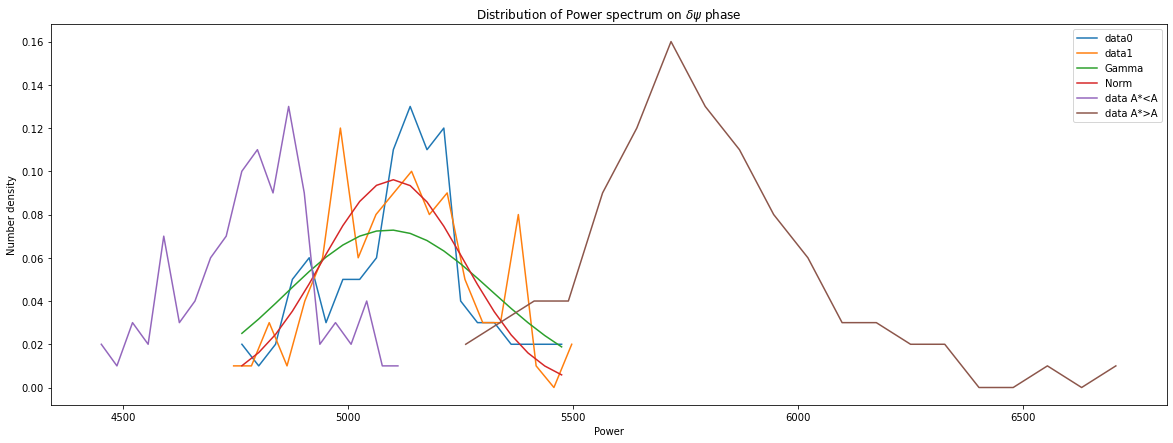

In [74]:
A_index0=11
B_index0=10

A_index1=21
B_index1=10

A_index2=31
B_index2=10

power0=(spectra[A_index0,B_index0]/Gamma_scales[A_index0,B_index0]).sum(axis=(-2,-1))
power1=(spectra[A_index1,B_index1]/Gamma_scales[A_index1,B_index1]).sum(axis=(-2,-1))
power_wrong=(spectra[A_index0,B_index0]/Gamma_scales[A_index1,B_index1]).sum(axis=(1,2))
power_wrong2=(spectra[A_index2,B_index2]/Gamma_scales[A_index1,B_index1]).sum(axis=(1,2))

data0,x0=np.histogram(power0,bins=20,density=True)
data1,x1=np.histogram(power1,bins=20,density=True)
dataw,xw=np.histogram(power_wrong,bins=20,density=True)
dataw2,xw2=np.histogram(power_wrong2,bins=20,density=True)

norm_data0=data0/data0.sum()
norm_data1=data1/data1.sum()
norm_dataw=dataw/dataw.sum()
norm_dataw2=dataw2/dataw2.sum()

k=500

m=sc.stats.gamma.pdf(x0[1:],a=k,loc=0,scale=power0.mean()/k)
n=sc.stats.norm.pdf(x0[1:],loc=power0.mean(),scale=power0.std())
l=sc.stats.norm.pdf(xw[1:],loc=power_wrong.mean(),scale=power_wrong.std())

plt.figure(figsize=(20,7))

plt.plot(x0[1:],norm_data0,label='data0')
plt.plot(x1[1:],norm_data1,label='data1')
plt.plot(x0[1:],m/m.sum(),label='Gamma')
plt.plot(x0[1:],n/n.sum(),label='Norm')

plt.plot(xw[1:],norm_dataw,label='data A*<A')
plt.plot(xw2[1:],norm_dataw2,label='data A*>A')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')


In [43]:
Total_powers=np.array([(spectra32[:,:,i,:,:]/Gamma_scales32).sum(axis=(-2,-1)) for i in range(100)])

In [44]:
Total_powers.shape

(100, 32, 16)

In [18]:
#Total_powers=(spectra.reshape((100,32,16,74,50))/Gamma_scales).sum(axis=(-2,-1))
#Total_powers=Total_powers.reshape((32,16,100))
Total_means=Total_powers.mean(axis=0)
Total_stds=Total_powers.std(axis=0)

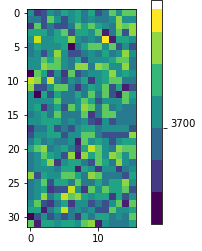

In [19]:
plt.imshow(Total_means)
plt.colorbar()

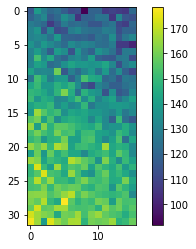

In [20]:
plt.imshow(Total_stds)
plt.colorbar()

3700.0
176.82588423454965


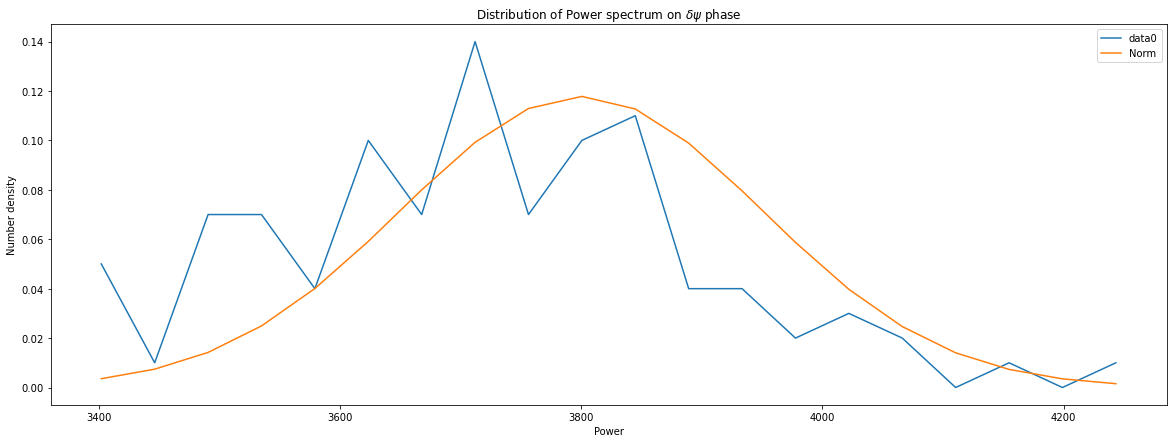

In [204]:
A_index0=31
B_index0=0


power0=(spectra[A_index0,B_index0]/Gamma_scales[A_index0,B_index0]).sum(axis=(-2,-1))

data0,x0=np.histogram(power0,bins=20,density=True)

norm_data0=data0/data0.sum()

k=500

m=sc.stats.gamma.pdf(x0[1:],a=k,loc=0,scale=power0.mean()/k)

plt.figure(figsize=(20,7))

plt.plot(x0[1:],norm_data0,label='data0')
plt.plot(x0[1:],n/n.sum(),label='Norm')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

print(power0.mean())
print(power0.std())



In [203]:
Total_stds[-1,0]

2092.2122350887234

In [205]:
Total_stds[-1,0]

2092.2122350887234

In [10]:
def Gamma_stats(spectra):
    Gamma_scales=spectra.mean(axis=2)
    Total_powers=np.array([(spectra[:,:,i,:,:]/Gamma_scales).sum(axis=(-2,-1)) for i in range(100)])
    Total_means=Total_powers.mean(axis=0)
    Total_stds=Total_powers.std(axis=0)
    return Gamma_scales,Total_means,Total_stds

# Loss map

In [10]:
del spectra

NameError: name 'spectra' is not defined

In [7]:
spectra32=np.abs(np.fft.fft2(Grid_batch32*Observation_conditions.annulus_mask))**2
#Due to masking high scales are absent
spectra32=spectra32[:,:,:,:,:51]

In [8]:
del Grid_batch32

In [13]:
spectra80=np.abs(np.fft.fft2(Grid_batch80*Observation_conditions.annulus_mask))**2
#Due to masking high scales are absent
spectra80=spectra80[:,:,:,:,:51]

In [14]:
del Grid_batch80

In [17]:
def get_Loss_grid(data_spec,Gamma_scales,Total_means,Total_stds):
    Loss_grid=np.zeros((Gamma_scales.shape[0],Gamma_scales.shape[1]))
    
    for i in tqdm(range(Gamma_scales.shape[0])):
        for j in range(Gamma_scales.shape[1]):
            total_power=(data_spec/Gamma_scales[i,j]).sum()
            Loss_grid[i,j]=((total_power-Total_means[i,j])/Total_stds[i,j])**2
            
    return Loss_grid

In [11]:
Gamma_scales32,Total_means32,Total_stds32=Gamma_stats(spectra32)
#Gamma_scales80,Total_means80,Total_stds80=Gamma_stats(spectra80)

In [12]:
Spectral_dof=2*np.ones_like(spectra32[0,0,0])
Spectral_dof[0,0]=1
Spectral_dof[0,50]=1
Spectral_dof[50,0]=1
Spectral_dof[50,50]=1

In [13]:
Gamma_scales32.shape

(32, 16, 100, 51)

In [18]:
data_spec=deepcopy(spectra32[16,8,0])
Loss_grid=get_Loss_grid(data_spec,Gamma_scales32,Total_means32,Total_stds32)

100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8587.74it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 5466.45it/s]

[-8.1, 1.221259842519685]


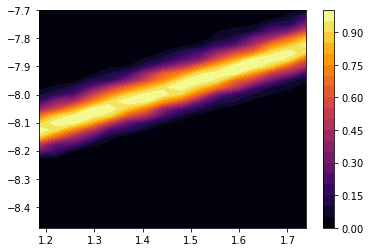

In [19]:
A_index0=15
B_index0=1

data_spec=deepcopy(spectra32[A_index0,B_index0,0])
Loss=get_Loss_grid(data_spec,Gamma_scales32,Total_means32,Total_stds32)

logA_batch,Beta_batch=coordinates(node_num,32)
GRF_params=[logA_batch[A_index0],Beta_batch[B_index0]]
print(GRF_params)

likelihood_new=np.exp(-Loss/2)

true_logA_index=np.argmin(np.abs(logA_batch-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_batch-GRF_params[1]))

likelihood=deepcopy(likelihood_new)

#likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)
pred_logA_index,pred_Beta_index=np.unravel_index(np.argmax(likelihood),shape=likelihood.shape)
#Confidence_grid=compute_Confidence_grid(likelihood)



from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage


levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
plt.contourf(Beta_batch,logA_batch,likelihood,levels, cmap='inferno')
plt.colorbar()
#ct.collections[0].set_label('Likelihood')



[-8.1, 1.4803149606299213]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8350.51it/s]


Text(0.4, 1.0, 'Likelihood')

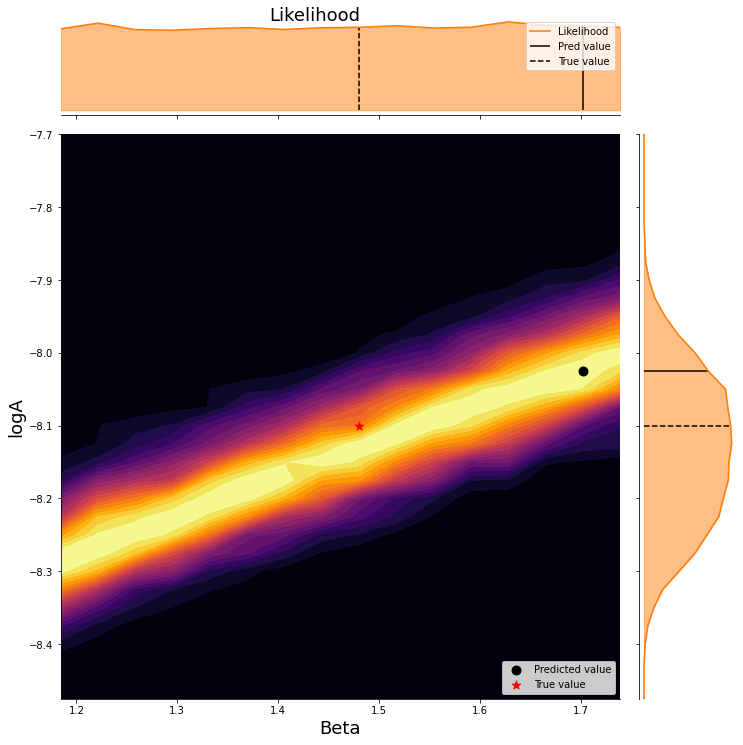

In [18]:
A_index0=15
B_index0=8


spectrum=spectra32[A_index0,B_index0,0]
logA_batch,Beta_batch=coordinates(node_num,32)

GRF_params=[logA_batch[A_index0],Beta_batch[B_index0]]
print(GRF_params)

Loss=get_Loss_grid(spectrum,Gamma_scales32,Total_means32,Total_stds32)
likelihood_new=np.exp(-Loss/2)

true_logA_index=np.argmin(np.abs(logA_batch-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_batch-GRF_params[1]))

likelihood=deepcopy(likelihood_new)

#likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)
pred_logA_index,pred_Beta_index=np.unravel_index(np.argmax(likelihood),shape=likelihood.shape)
#Confidence_grid=compute_Confidence_grid(likelihood)



from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_batch,logA_batch,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')


g.ax_joint.scatter(Beta_batch[pred_Beta_index],logA_batch[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_batch[true_Beta_index],logA_batch[true_logA_index],label='True value',marker="*",s=80,color='r')


#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_batch,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_batch,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_batch[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')



g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_batch,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_batch,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_batch[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

In [19]:
likelihood_Alpha=deepcopy(likelihood)

In [35]:
from GRF_perturbations.Modules.Inference import infer_LogNorm_params,compute_Loss_grid,Spectra_Loss

In [22]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
k_vector=np.fft.fftfreq(100,0.08)
kx,ky=np.meshgrid(k_vector,k_vector)
kx=kx[:,:51]
ky=ky[:,:51]
k_reduced_grid=k_grid[:,:51]

init_freq_index=4
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125)
#k_values=np.logspace(np.log10(0.5),np.log10(6.25),300)
Ring_masks=np.zeros((len(k_values)-init_freq_index,k_reduced_grid.shape[0],k_reduced_grid.shape[1]),dtype=bool)
Gamma_shapes=np.zeros(len(k_values)-init_freq_index)

for i in range(init_freq_index,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i-init_freq_index]=np.logical_and((k_reduced_grid>=k_values[i-1]),(k_reduced_grid<k_values[i]))
        Gamma_shapes[i-init_freq_index]=Spectral_dof[Ring_masks[i-init_freq_index]].sum()/2

In [23]:
def Radial_profile(spectrum):
    normalised_spectrum=spectrum/Observation_conditions.annulus_mask.sum()
    return np.array([normalised_spectrum[mask].sum()/mask.sum() for mask in Ring_masks])

In [24]:
RP_tensor=np.zeros((spectra32.shape[0],spectra32.shape[1],spectra32.shape[2],len(Ring_masks)))

for i in tqdm(range(spectra32.shape[0])):
    for j in range(spectra32.shape[1]):
        for q in range(spectra32.shape[2]):
            RP_tensor[i,j,q]=Radial_profile(spectra32[i,j,q])

100%|███████████████████████████████████████████| 32/32 [00:18<00:00,  1.74it/s]


In [26]:
data_spectrum=RP_tensor[A_index0,B_index0,0]
data_logSpectrum=np.log(data_spectrum)

Estimated_Noise_spectral_density=(Observation_conditions.noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

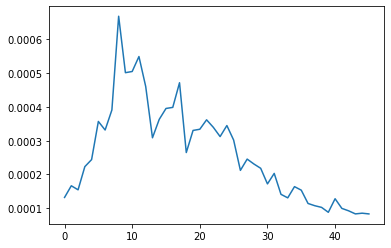

In [27]:
plt.plot(RP_tensor[20,8,0])

In [29]:
def normalise_spectrum(model_spectrum,data_spectrum,Estimated_Noise_spectral_density):
    factor=(model_spectrum.sum()-Estimated_Noise_spectral_density*len(data_spectrum))/(model_spectrum.sum()-Estimated_Noise_spectral_density*len(data_spectrum))
    return model_spectrum*factor

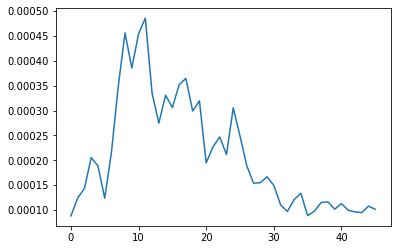

In [30]:
plt.plot(data_spectrum)

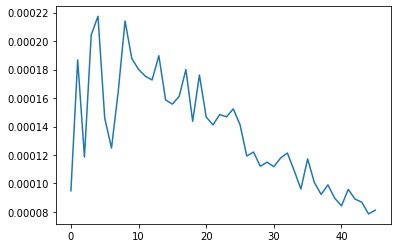

In [32]:
plt.plot(normalise_spectrum(RP_tensor[0,8,0],data_spectrum,Estimated_Noise_spectral_density))

In [33]:
Normalised_Spectra_grid=np.zeros_like(RP_tensor)

for i in tqdm(range(spectra32.shape[0])):
    for j in range(spectra32.shape[1]):
        for q in range(spectra32.shape[2]):
            Normalised_Spectra_grid[i,j,q]=normalise_spectrum(RP_tensor[i,j,q],data_spectrum,Estimated_Noise_spectral_density)

100%|███████████████████████████████████████████| 32/32 [00:05<00:00,  6.40it/s]


In [34]:
def Spectra_Loss(model_spectra,data_logSpectrum):

    #Infer mu of model's LogNormal distribution
    mean=jnp.mean(model_spectra,axis=0)
    variance=jnp.power(jnp.std(model_spectra,axis=0),2)
    sigma_model=jnp.sqrt(jnp.log(1+variance/jnp.power(mean,2)))
    mu_model=jnp.log(mean)-jnp.power(sigma_model,2)/2

    #-LogLikelihood for LogNormal distribution
    chi_sq=jnp.mean(jnp.power((data_logSpectrum-mu_model)/sigma_model,2))

    return chi_sq


def compute_Loss_grid(Spectra_grid,Spectra_Loss_pure):

    #map function over row of Betas_array and GRF_seeds
    def loop_over_Betas(Spectra_Beta_row):
        return jax_map(Spectra_Loss_pure,Spectra_Beta_row)

    Loss_grid=jax_map(loop_over_Betas,Spectra_grid)

    return Loss_grid

data_spectrum=RP_tensor[A_index0,B_index0,0]
data_logSpectrum=np.log(data_spectrum)
Spectra_Loss_pure=jax.jit(lambda model_spectra: Spectra_Loss(model_spectra,data_logSpectrum))

In [35]:
Spectra_Loss_pure(data_spectrum)

DeviceArray(1.07820834, dtype=float64)

In [40]:
Loss_grid=compute_Loss_grid(Normalised_Spectra_grid,Spectra_Loss_pure)

[-8.1, 1.4803149606299213]


Text(0.4, 1.0, 'Likelihood')

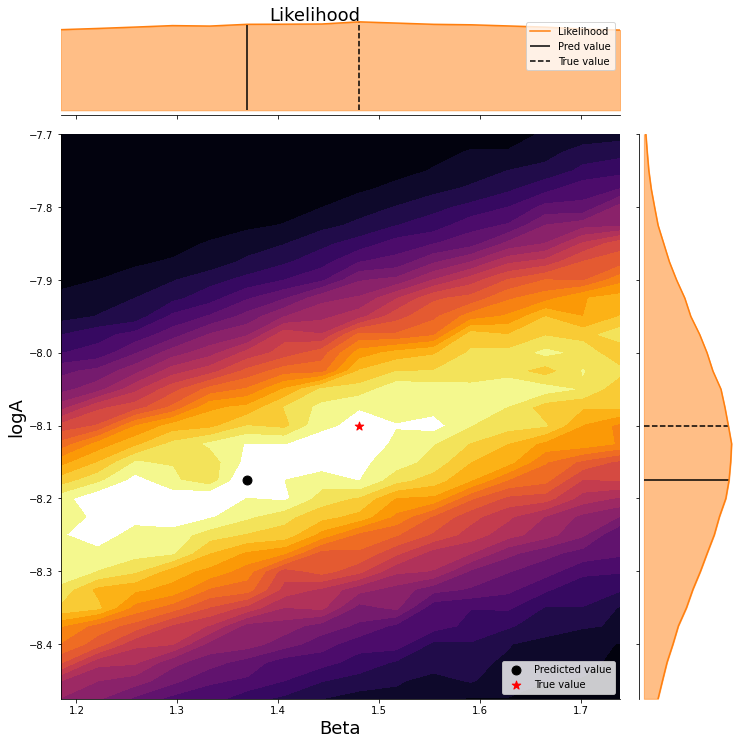

In [41]:
A_index0=15
B_index0=8

GRF_params=[logA_batch[A_index0],Beta_batch[B_index0]]
spectrum=spectra32[A_index0,B_index0,0]
print(GRF_params)

Loss=Loss_grid
likelihood_new=np.exp(-Loss/2)

true_logA_index=np.argmin(np.abs(logA_batch-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_batch-GRF_params[1]))

likelihood=deepcopy(likelihood_new)

#likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)
pred_logA_index,pred_Beta_index=np.unravel_index(np.argmax(likelihood),shape=likelihood.shape)
#Confidence_grid=compute_Confidence_grid(likelihood)



from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_batch,logA_batch,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')


g.ax_joint.scatter(Beta_batch[pred_Beta_index],logA_batch[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_batch[true_Beta_index],logA_batch[true_logA_index],label='True value',marker="*",s=80,color='r')


#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_batch,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_batch,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_batch[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')



g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_batch,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_batch,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_batch[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

In [42]:
likelihood_Beta=deepcopy(likelihood)

In [43]:
Likelihood=likelihood_Alpha*likelihood_Beta

Text(0.4, 1.0, 'Likelihood')

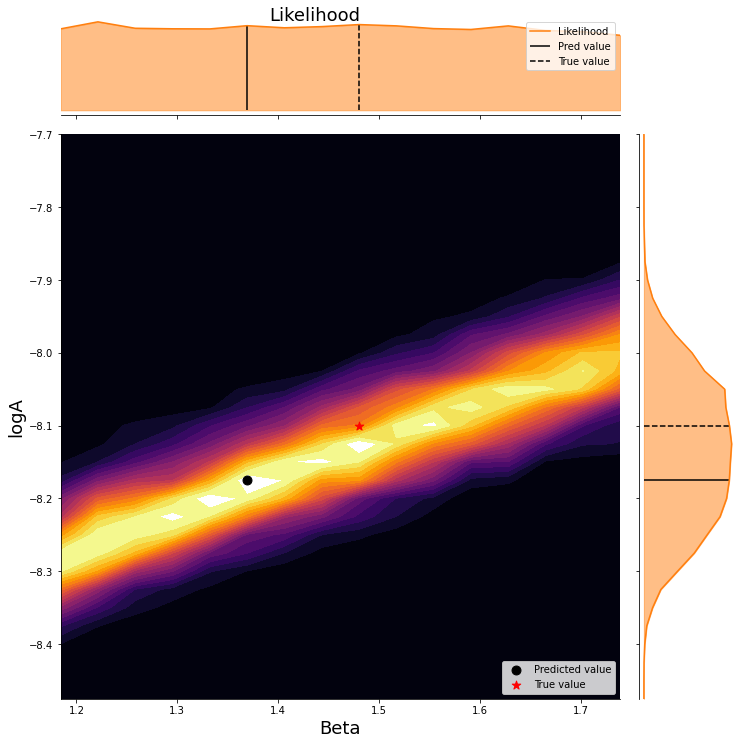

In [44]:
A_index0=15
B_index0=8

GRF_params=[logA_batch[A_index0],Beta_batch[B_index0]]

likelihood_new=deepcopy(Likelihood)

true_logA_index=np.argmin(np.abs(logA_batch-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_batch-GRF_params[1]))

likelihood=deepcopy(likelihood_new)

#likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)
pred_logA_index,pred_Beta_index=np.unravel_index(np.argmax(likelihood),shape=likelihood.shape)
#Confidence_grid=compute_Confidence_grid(likelihood)



from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_batch,logA_batch,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')


g.ax_joint.scatter(Beta_batch[pred_Beta_index],logA_batch[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_batch[true_Beta_index],logA_batch[true_logA_index],label='True value',marker="*",s=80,color='r')


#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_batch,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_batch,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_batch[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')



g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_batch,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_batch,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_batch[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

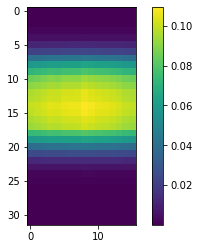

In [1235]:
plt.imshow(likelihood)
plt.colorbar()

## predict scale

In [24]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
k_vector=np.fft.fftfreq(100,0.08)
kx,ky=np.meshgrid(k_vector,k_vector)
kx=kx[:,:51]
ky=ky[:,:51]
k_reduced_grid=k_grid[:,:51]
def map_spec_to_radial(Spectrum,k_grid):
    
    #k_values=np.arange(0,np.abs(np.fft.fftfreq(100,0.08)).max(),0.125)
    k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
    #k_values=np.unique(k_grid)
    radial_spectrum=np.zeros_like(k_values)
    radial_errorbars=np.zeros((2,len(k_values)))
    counts=np.zeros_like(k_values)
    
    for i in range(1,len(k_values)):
        mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])
        #mask=k_grid==k_values[i]
        counts[i]=mask.sum()
        if mask.sum()==0:
            radial_spectrum[i]=np.nan
            radial_errorbars[0,i]=np.nan
            radial_errorbars[1,i]=np.nan
            continue
        radial_spectrum[i]=Spectrum[mask].mean()
        radial_errorbars[0,i]=radial_spectrum[i]-Spectrum[mask].min()
        radial_errorbars[1,i]=Spectrum[mask].max()-radial_spectrum[i]
        
        
    return k_values,radial_spectrum,radial_errorbars,counts

In [64]:
def map_spec_to_radialx(Spectrum,k_grid):
    
    k_values=np.fft.fftfreq(100,0.08)[:50]
    radial_spectrum=np.zeros_like(k_values)
    radial_errorbars=np.zeros((2,len(k_values)))
    counts=np.zeros_like(k_values)
    
    for i in range(0,len(k_values)):
        radial_spectrum[i]=Spectrum[:,i].mean()
        radial_errorbars[0,i]=radial_spectrum[i]-Spectrum[:,i].min()
        radial_errorbars[1,i]=Spectrum[:,i].max()-radial_spectrum[i]
        
        
    return k_values,radial_spectrum,radial_errorbars,counts

In [29]:
Gamma_scales.shape

(32, 16, 74, 50)

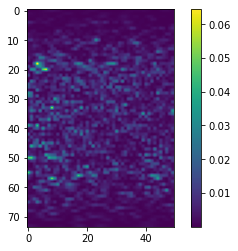

In [67]:
plt.imshow(spectra80[0,-1,0])
plt.colorbar()

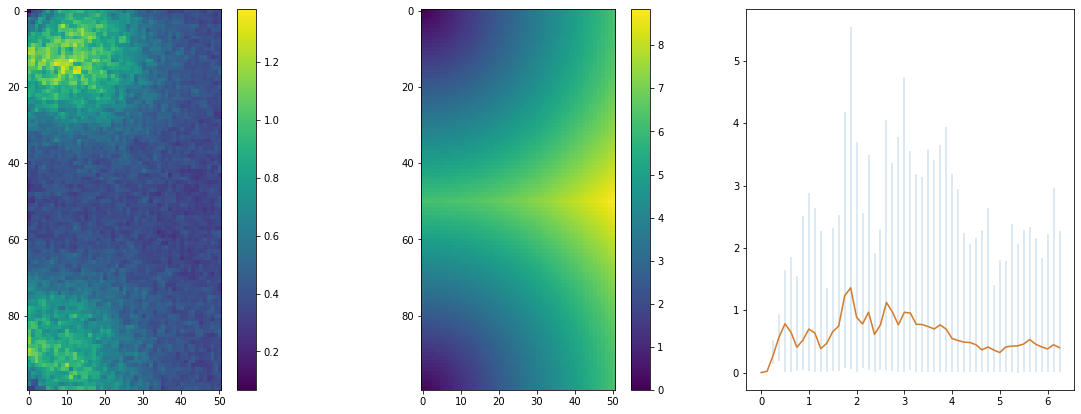

In [556]:
A_index0=0
B_index0=0
phi_index=0

fig,ax=plt.subplots(1,3,figsize=(20,7))
img=ax[0].imshow(Gamma_scales32[A_index0,B_index0])
fig.colorbar(img,ax=ax[0])
img=ax[1].imshow(k_reduced_grid)
fig.colorbar(img,ax=ax[1])

spectrum=spectra32[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_reduced_grid)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars,alpha=0.2)
ax[2].plot(k_values,radial_spectrum)
plt.show()

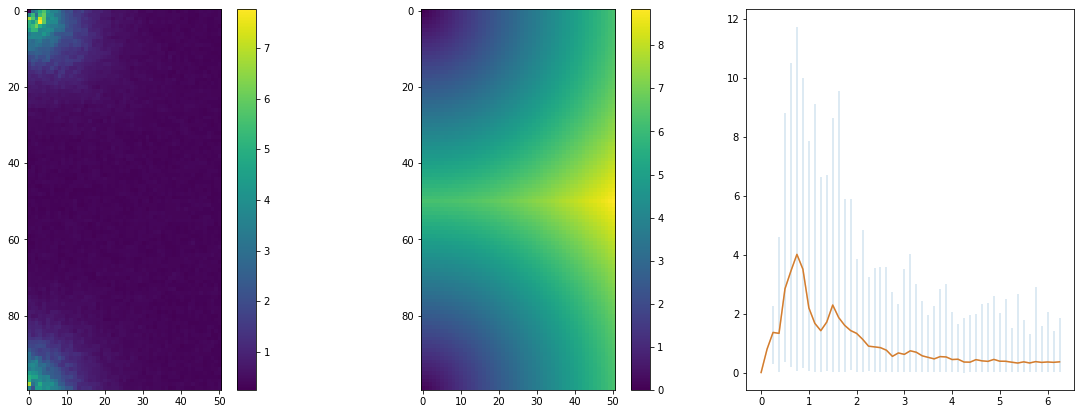

In [32]:
A_index0=-1
B_index0=15
phi_index=0

fig,ax=plt.subplots(1,3,figsize=(20,7))
img=ax[0].imshow(Gamma_scales80[A_index0,B_index0])
fig.colorbar(img,ax=ax[0])
img=ax[1].imshow(k_reduced_grid)
fig.colorbar(img,ax=ax[1])

spectrum=spectra80[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_reduced_grid)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars,alpha=0.2)
ax[2].plot(k_values,radial_spectrum)
plt.show()

1.1792476415070754 1.1858541225631423


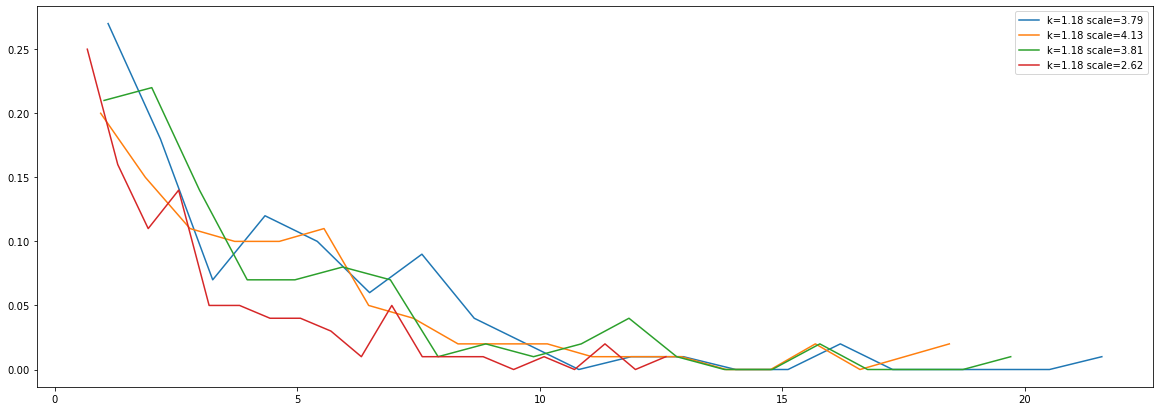

In [37]:
A_index0=31
B_index0=0

k_values=np.unique(k_reduced_grid)
i=40
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

indices=np.where(mask)

plt.figure(figsize=(20,7))

for i in range(len(indices[0])):
    data,x=np.histogram(spectra32[A_index0,B_index0,:,indices[0][i],indices[1][i]],bins=20,density=True)
    norm_data=data/data.sum()
    plt.plot(x[1:],norm_data,label='k={:.2f} scale={:.2f}'.format(k_reduced_grid[indices[0][i],indices[1][i]],Gamma_scales32[A_index0,B_index0,indices[0][i],indices[1][i]]))
    
plt.legend()
plt.show()




2.125 2.25


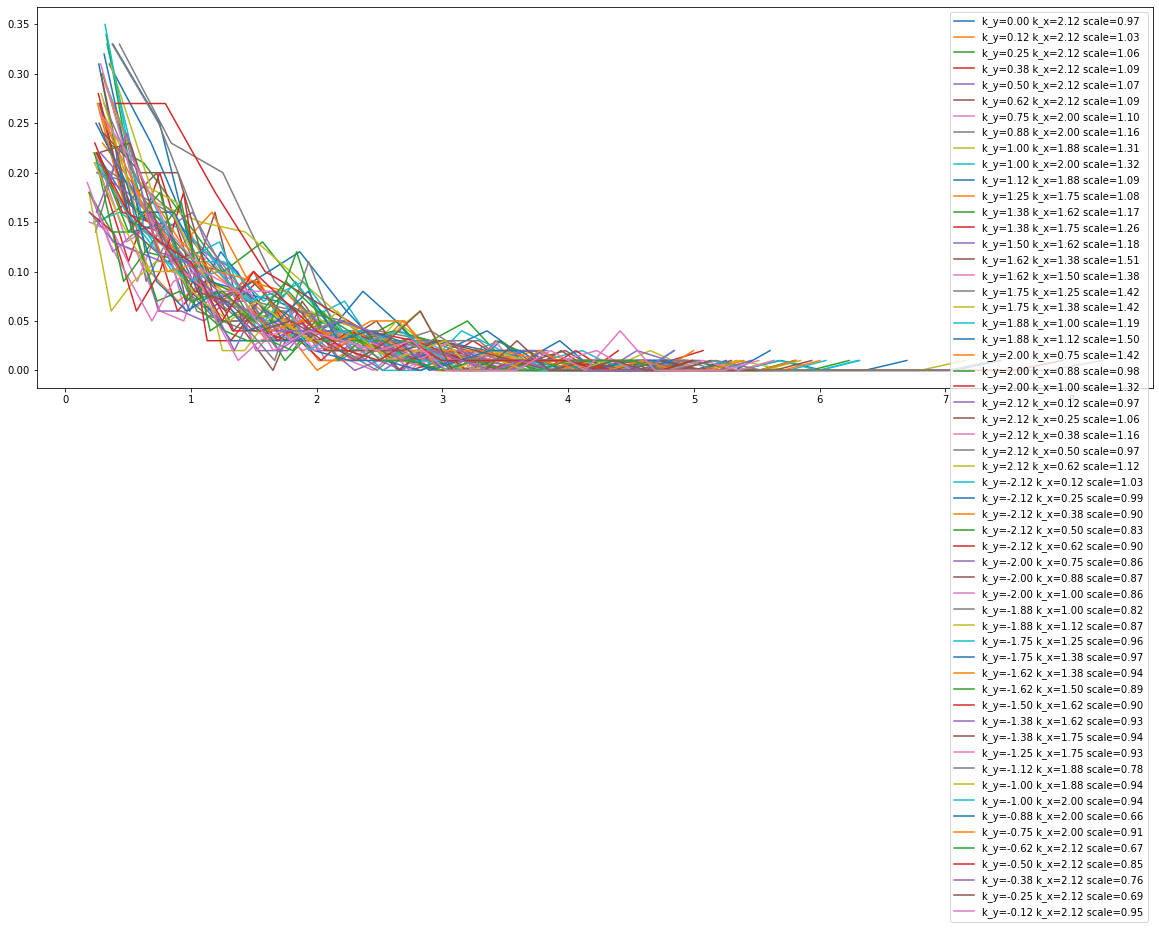

In [109]:
A_index0=31
B_index0=10

k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
i=18
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])&(kx>0)

indices=np.where(mask)

plt.figure(figsize=(20,7))

for i in range(len(indices[0])):
    data,x=np.histogram(spectra32[A_index0,B_index0,:,indices[0][i],indices[1][i]]/Gamma_scales32[A_index0,B_index0,indices[0][i],indices[1][i]],bins=20,density=True)
    norm_data=data/data.sum()
    plt.plot(x[1:],norm_data,label='k_y={:.2f} k_x={:.2f} scale={:.2f}'.format(ky[indices[0][i],indices[1][i]],kx[indices[0][i],indices[1][i]],\
                                                                               np.log(Gamma_scales32[A_index0,B_index0,indices[0][i],indices[1][i]])))
    
plt.legend()
plt.show()





In [50]:
spectra32[A_index0,B_index0,:,mask].shape

(59, 100)

In [52]:
spectrum=np.array([((spectra32[A_index0,B_index0,i])[mask]).sum() for i in range(100)])

In [1074]:
spectra32.shape

(32, 16, 100, 100, 51)

In [1059]:
import scipy as sc

A_index0=15
B_index0=8

A_index1=15
B_index1=8

i=50

spectr=spectra80
Gamma=Gamma_scales80
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125/2)
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

spectrum=np.array([((spectr[A_index1,B_index1,i])[mask]) for i in range(100)]).ravel()

3.0625 3.125


1.8125 1.875
16


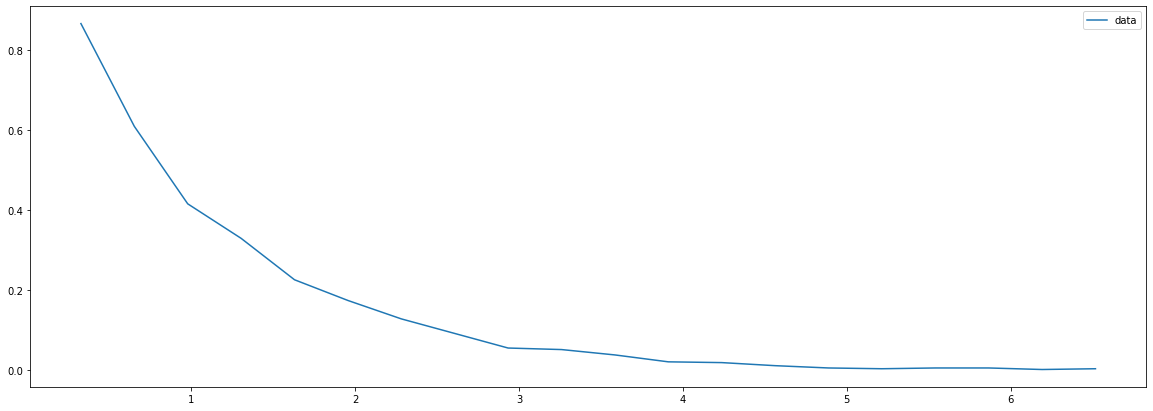

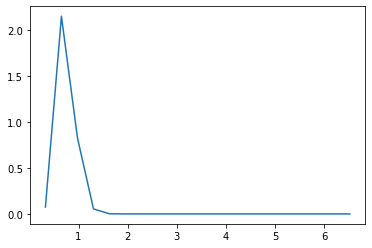

In [1073]:
import scipy as sc

A_index0=15
B_index0=8

A_index1=15
B_index1=8

i=30

spectr=spectra80
Gamma=Gamma_scales80
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125/2)
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

spectrum=np.array([((spectr[A_index1,B_index1,i])[mask]/Gamma[A_index1,B_index1,mask]) for i in range(100)]).ravel()

data0,x0=np.histogram(spectrum,bins=20,density=True)

distr_shape=Spectral_dof[mask].sum()/2


m=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=Gamma_scales32[A_index0,B_index0,mask].mean())
l=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=Gamma[A_index0,B_index0,mask].mean()/mask.sum())


plt.figure(figsize=(20,7))

#plt.plot(x0[1:],data0/sc.special.gamma(distr_shape),label='data b=2')
plt.plot(x0[1:],data0,label='data')
#plt.plot(x0[1:],m/m.sum(),label='Gamma {:.2f}'.format(distr_shape))
#plt.plot(x0[1:],l,label='model')

print(mask.sum())

plt.legend()
plt.show()

def Gamma_logLikelihood(value,shape,scale):
    return (shape-1)*np.log(value)-shape*np.log(scale)-np.log(sc.special.gamma(shape))-value/scale

plt.plot(x0[1:],np.exp(Gamma_logLikelihood(x0[1:],distr_shape,Gamma[A_index0,B_index0,mask].mean()/mask.sum())))
plt.show()

In [1070]:
spectr[A_index1,B_index1,i][mask]

array([1.19612716, 0.13446302, 1.34723584, 0.71371444, 0.26669841,
       1.11284618, 0.67381994, 0.0453809 , 0.7827717 , 1.58301929,
       0.04956318, 0.04636842, 0.28570569, 0.81718557, 0.3322198 ,
       0.89321082])

3.0625 3.125
0.8491595387767503 1.1126913360390565 1.7190454756811038
28


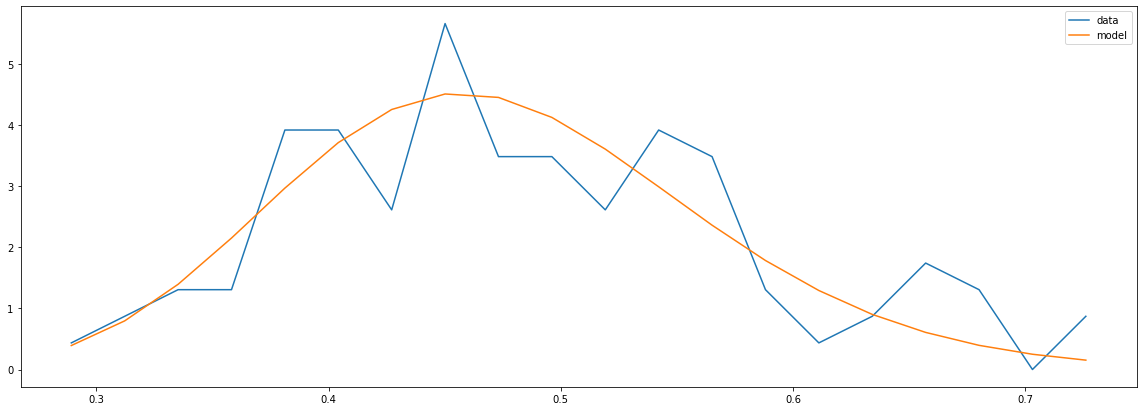

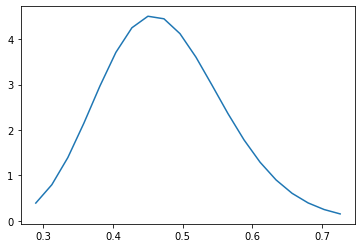

In [1016]:
import scipy as sc

A_index0=15
B_index0=8

A_index1=15
B_index1=8

i=50

spectr=spectra80
Gamma=Gamma_scales80
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125/2)
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

spectrum=np.array([((spectr[A_index1,B_index1,i])[mask]).sum()/mask.sum() for i in range(100)])

print(Gamma_scales32[A_index0,B_index0,mask].min(),Gamma_scales32[A_index0,B_index0,mask].mean(),Gamma_scales32[A_index0,B_index0,mask].max())

data0,x0=np.histogram(spectrum,bins=20,density=True)

distr_shape=Spectral_dof[mask].sum()/2


m=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=Gamma_scales32[A_index0,B_index0,mask].mean())
l=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=Gamma[A_index0,B_index0,mask].mean()/mask.sum())


plt.figure(figsize=(20,7))

#plt.plot(x0[1:],data0/sc.special.gamma(distr_shape),label='data b=2')
plt.plot(x0[1:],data0,label='data')
#plt.plot(x0[1:],m/m.sum(),label='Gamma {:.2f}'.format(distr_shape))
plt.plot(x0[1:],l,label='model')

print(mask.sum())

plt.legend()
plt.show()

def Gamma_logLikelihood(value,shape,scale):
    return (shape-1)*np.log(value)-shape*np.log(scale)-np.log(sc.special.gamma(shape))-value/scale

plt.plot(x0[1:],np.exp(Gamma_logLikelihood(x0[1:],distr_shape,Gamma[A_index0,B_index0,mask].mean()/mask.sum())))
plt.show()

# predict values

In [1045]:
len(np.unique(k_reduced_grid))

1031

In [1046]:
np.unique(k_reduced_grid)

array([0.        , 0.125     , 0.1767767 , ..., 8.66386173, 8.75089281,
       8.83883476])

In [1050]:
np.abs(np.fft.fftfreq(100,0.08)).max()

6.25

In [1090]:
init_freq_index=4
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125)
#k_values=np.logspace(np.log10(0.5),np.log10(6.25),300)
Ring_masks=np.zeros((len(k_values)-init_freq_index,k_reduced_grid.shape[0],k_reduced_grid.shape[1]),dtype=bool)
Gamma_shapes=np.zeros(len(k_values)-init_freq_index)

for i in range(init_freq_index,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i-init_freq_index]=np.logical_and((k_reduced_grid>=k_values[i-1]),(k_reduced_grid<k_values[i]))
        Gamma_shapes[i-init_freq_index]=Spectral_dof[Ring_masks[i-init_freq_index]].sum()/2

In [1055]:
Ring_masks.shape

(289, 100, 51)

In [1056]:
print(Ring_masks.sum(axis=(1,2)))

[ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  7  0  4  0  0  0  0  0
  0  4  0  0  0  0  0  2  0  0  4  0  0  3  0  4  0  0  0  0  4  4  0  0
  0  0  0  4  0  0  0  0  3  6  0  4  4  0  0  0  0  0  4  0  0  4  0  0
 11  0  0  4  0  0  0  6  4  0  0  0  0  7  4  0  8  0  0  4  4  0  0  0
  4  2  7  4  4  4  0  4  0  4  0  8  0  3  4  8  0  2  8  0  4  4  0  0
 15  4  4  4  0  4  4  6  0 15  4  0  4  8  8  0  0  8  7  6 12  4  4  0
  4  8 11  4 12  0  6  8  8  0  7 12  8  8  8  4  0 21  8  4 12  0 12  4
 19  4 18  4  4  8 11 20  4  8 12  6 15 20  4  8 12  8 19 14 12 12  4 23
 16  8 12  6 16 19 20 12 16  4 25 20  8 20 15 20 12 26  8 27 20 16 12 22
 27 12 24 20 15 30 16 24 23 24 24 22 31 16 32 20 33 32 12 28 31 24 34 23
 40 32 12 45 24 32 39 34 28 28 51 24 38 43 32 36 43 42 24 59 40 26 51 48
 44 45 44 44 59 46 28 67 44 61 56 44 51 58 44 75 50 63 64 48 73 44 75 66
 52]


In [1027]:
def Gamma_logLikelihood(value,shape,scale):
    return (shape-1)*np.log(value)-value/scale-shape*np.log(scale)-np.log(sc.special.gamma(shape))

In [1028]:
def Loss(spectrum,Gamma_scales,Ring_masks,Gamma_shapes):
    logLikelihoods=np.zeros_like(Gamma_shapes)
    
    Radial_spectrum=np.array([(spectrum[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])
    for i in range(len(Gamma_shapes)):
        logLikelihoods[i]=Gamma_logLikelihood(Radial_spectrum[i],Gamma_shapes[i],Gamma_scales.mean()/Ring_masks[i].sum())
        
    return logLikelihoods

In [1029]:
Loss(spectra32[A_index1,B_index1,0],Gamma_scales32[A_index0,B_index0],Ring_masks,Gamma_shapes)

array([  0.15568485,  -0.6407846 ,  -0.11568746,  -0.12205757,
        -0.15368018,   0.56022565,   0.60359686,   0.66487716,
        -0.03459195,  -1.18500891, -10.19739739,  -4.19017774,
       -20.1382023 ,  -7.71726639, -17.34457528,  -5.10030157,
       -27.1066219 , -11.53950448, -31.95280765, -11.2212959 ,
        -5.82858343, -12.12631277,  -5.74350068,  -2.4520071 ,
       -14.58334707,  -5.64945146, -11.7537159 ,  -4.16546713,
       -11.6603342 , -14.19055913, -15.82491344, -13.23044826,
        -9.39155629,  -8.07472996, -11.16439231,  -9.88691791,
        -0.08218822,   0.42930265,  -3.75999979,  -0.26215398,
        -4.70739032,  -3.57397886,  -0.52825667,  -1.77504547,
        -2.97193865, -21.53274015,  -7.64167719,  -1.07225549,
        -0.96452757,   1.21914762,   1.52848643,   1.15564564,
         1.56553148,   1.32664567,   1.41391082,   1.14012562,
         1.30110072,   0.43656445,  -1.52563489,  -1.33465293,
        -5.83188623,  -1.13527756,  -1.76445597,   0.99

In [1030]:
Beta_batch

array([1.18425197, 1.22125984, 1.25826772, 1.29527559, 1.33228346,
       1.36929134, 1.40629921, 1.44330709, 1.48031496, 1.51732283,
       1.55433071, 1.59133858, 1.62834646, 1.66535433, 1.7023622 ,
       1.73937008])

-7.360090527442588


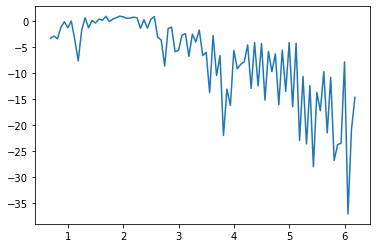

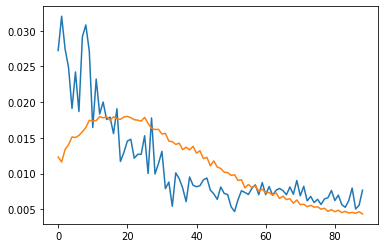

In [1038]:
A_index0=15
B_index0=0

A_index1=15
B_index1=8

phi=3

q=Loss(spectra80[A_index1,B_index1,phi],Gamma_scales32[A_index0,B_index0],Ring_masks,Gamma_shapes)
plt.plot(k_values[init_freq_index:],q)
print(q.mean())
plt.show()

Radial_spectrum1=np.array([(spectra80[A_index1,B_index1,phi][Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])
Radial_spectrum0=np.array([np.array([(spectra32[A_index0,B_index0,j][Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])  for j in range(100)]).mean(axis=0)
plt.plot(Radial_spectrum1/Radial_spectrum1.sum())
plt.plot(Radial_spectrum0/Radial_spectrum0.sum())
plt.show()



-1.2980361195911876


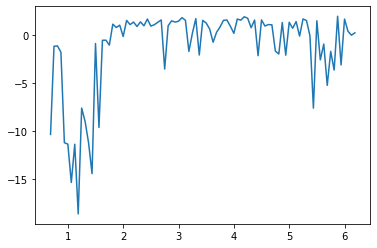

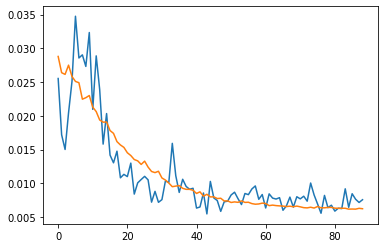

In [1042]:
A_index0=15
B_index0=0

A_index1=15
B_index1=8

phi=1

q=Loss(spectra80[A_index1,B_index1,phi],Gamma_scales80[A_index0,B_index0],Ring_masks,Gamma_shapes)
plt.plot(k_values[init_freq_index:],q)
print(q.mean())
plt.show()

Radial_spectrum1=np.array([(spectra80[A_index1,B_index1,phi][Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])
Radial_spectrum0=np.array([np.array([(spectra80[A_index0,B_index0,j][Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])  for j in range(100)]).mean(axis=0)
plt.plot(Radial_spectrum1/Radial_spectrum1.sum())
plt.plot(Radial_spectrum0/Radial_spectrum0.sum())
plt.show()




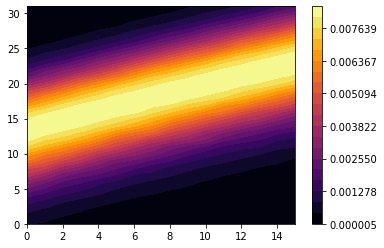

In [1036]:
A_index1=15
B_index1=8
data_spec=deepcopy(spectra32[A_index1,B_index1,0])

Loss_grid=np.zeros((spectra32.shape[0],spectra32.shape[1]))
for i in range(spectra32.shape[0]):
    for j in range(spectra32.shape[1]):
        Loss_grid[i,j]=np.mean(Loss(data_spec,Gamma_scales32[i,j],Ring_masks,Gamma_shapes))
        
#likelihood=np.exp(Loss_grid)
logA_batch,Beta_batch=coordinates(2,32)
likelihood=np.exp(Loss_grid)
levels=np.linspace(likelihood.min(),likelihood.max(),21)
plt.contourf(likelihood,levels, cmap='inferno')
plt.colorbar()

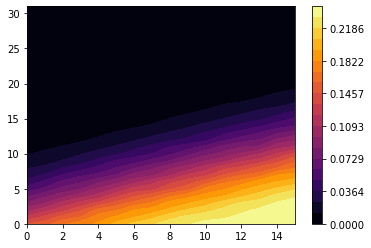

In [1037]:
A_index1=15
B_index1=8
data_spec=deepcopy(spectra80[A_index1,B_index1,0])

Loss_grid=np.zeros((spectra32.shape[0],spectra32.shape[1]))
for i in range(spectra32.shape[0]):
    for j in range(spectra32.shape[1]):
        Loss_grid[i,j]=np.mean(Loss(data_spec,Gamma_scales32[i,j],Ring_masks,Gamma_shapes))
        
#likelihood=np.exp(Loss_grid)
logA_batch,Beta_batch=coordinates(2,32)
likelihood=np.exp(Loss_grid)
levels=np.linspace(likelihood.min(),likelihood.max(),21)
plt.contourf(likelihood,levels, cmap='inferno')
plt.colorbar()

In [872]:
from GRF_perturbations.Modules.Inference import compute_Confidence_grid

In [948]:
confidence_grid=compute_Confidence_grid(np.exp(Loss_grid))

-9.016468324311589


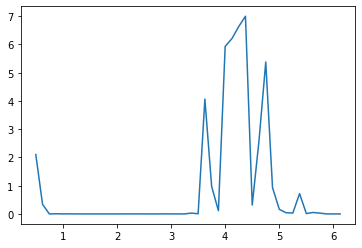

In [899]:
A_index0=15
B_index0=-1

A_index1=15
B_index1=-1

q=Loss(spectra32[A_index1,B_index1,0],Gamma_scales32[A_index0,B_index0],Ring_masks,Gamma_shapes)
plt.plot(k_values[init_freq_index:],np.exp(q))
print(q.mean())

-6.485723892904379


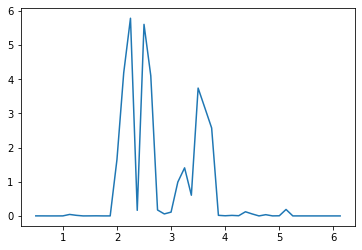

In [897]:
A_index0=0
B_index0=0

A_index1=15
B_index1=-1

q=Loss(spectra80[A_index1,B_index1,0],Gamma_scales32[A_index0,B_index0],Ring_masks,Gamma_shapes)
plt.plot(k_values[init_freq_index:],np.exp(q))
print(q.mean())

In [474]:
np.linspace(0,(likelihood.max()*10).round()/10,21)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [475]:
likelihood.max()

0.03522047730386213

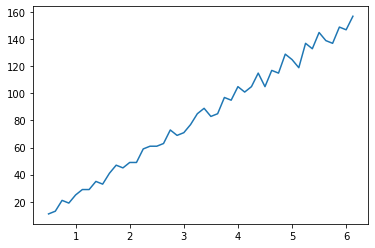

In [450]:
plt.plot(k_values[init_freq_index:],Ring_masks.sum(axis=(1,2)))

In [378]:
Ring_masks[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [379]:
len(np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125/2))

100

In [380]:
len(k_values)

89

In [29]:
del Grid_batch32

In [30]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

In [31]:
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase
Anomalies_spectra=np.zeros((1000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(1000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,True,noise_seed)
    Anomalies_images=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft2(Anomalies_images))**2

100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.06it/s]


In [32]:
from GRF_perturbations.Modules.Image_processing import compute_radial_spectrum,Radial_profile

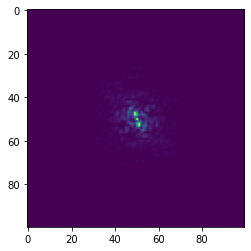

In [33]:
plt.imshow(np.fft.fftshift(Anomalies_spectra[0]))

In [1091]:
Radial_spectrum1=np.array([((Anomalies_spectra[0,:,:51])[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))])

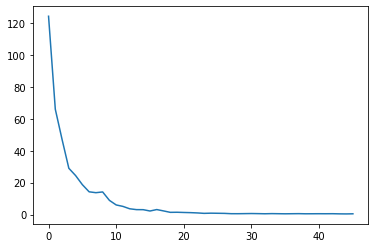

In [1093]:
plt.plot(Radial_spectrum1)

In [ ]:
RP_old=np.array([Radial_profile(np.fft.fftshift(Anomalies_spectra[i]),(100,100)) for i in tqdm(range(300))])
RP_new=np.array([ np.array([((Anomalies_spectra[j,:,:51])[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))]) for j in tqdm(range(300))])

In [1112]:
RP_old.shape

(300, 50)

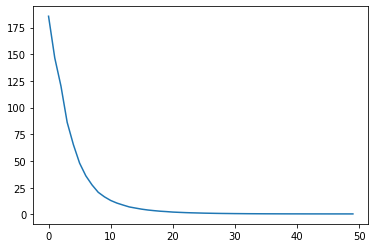

In [1113]:
plt.plot(RP_old.mean(axis=0))

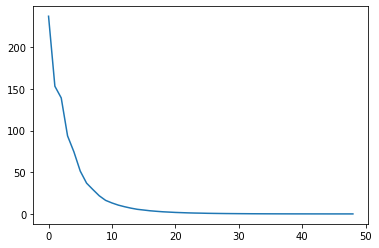

In [1114]:
plt.plot(RP_new.mean(axis=0))

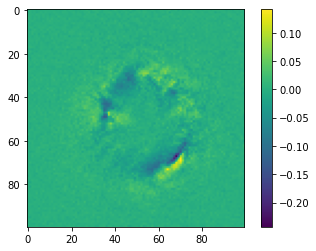

In [1129]:
plt.imshow(Anomalies_images)
plt.colorbar()

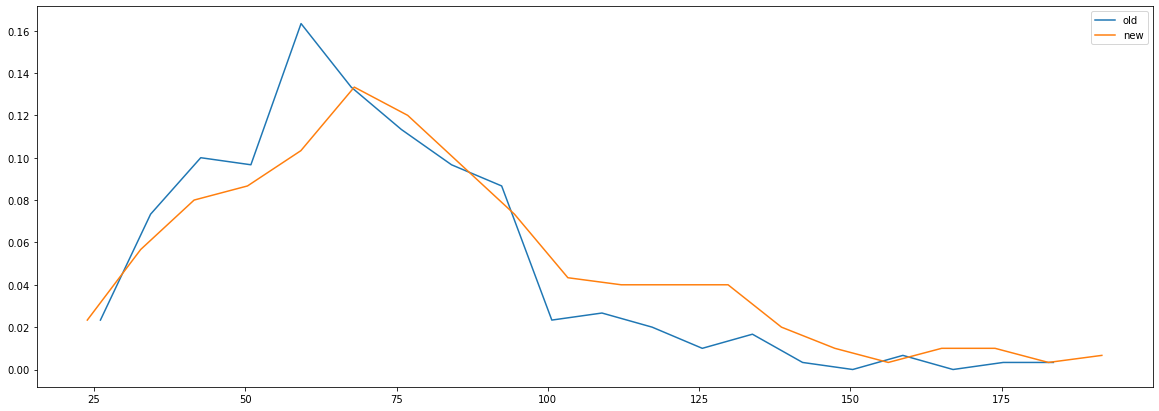

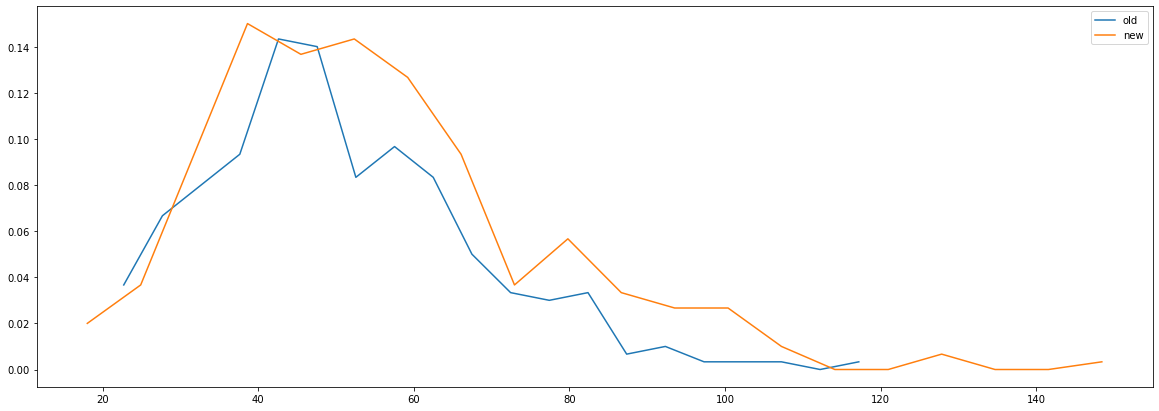

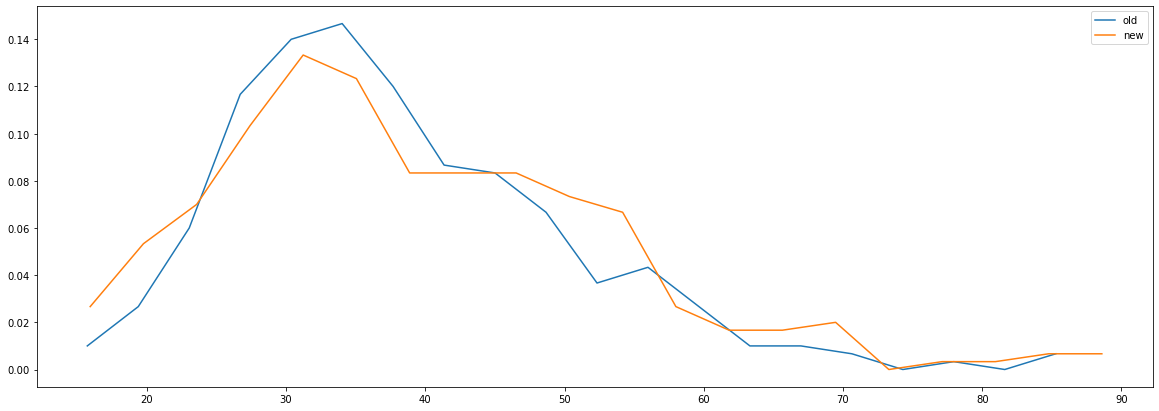

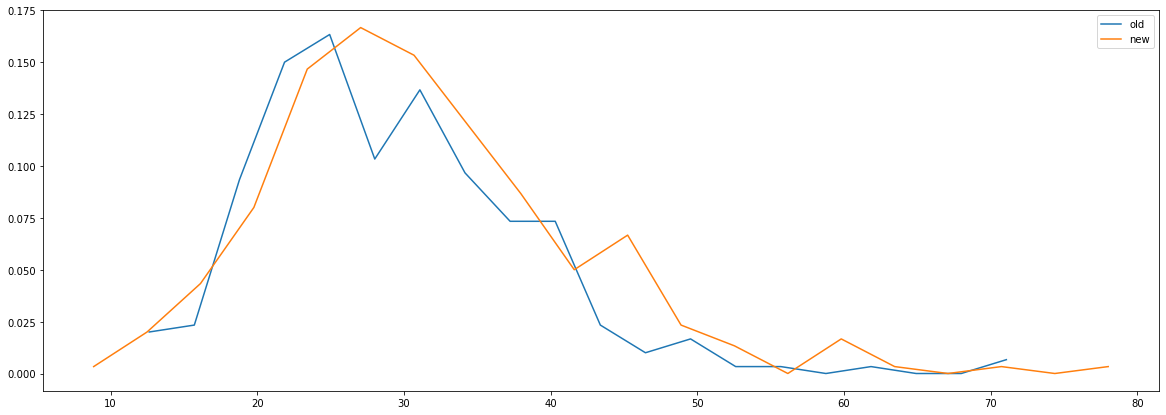

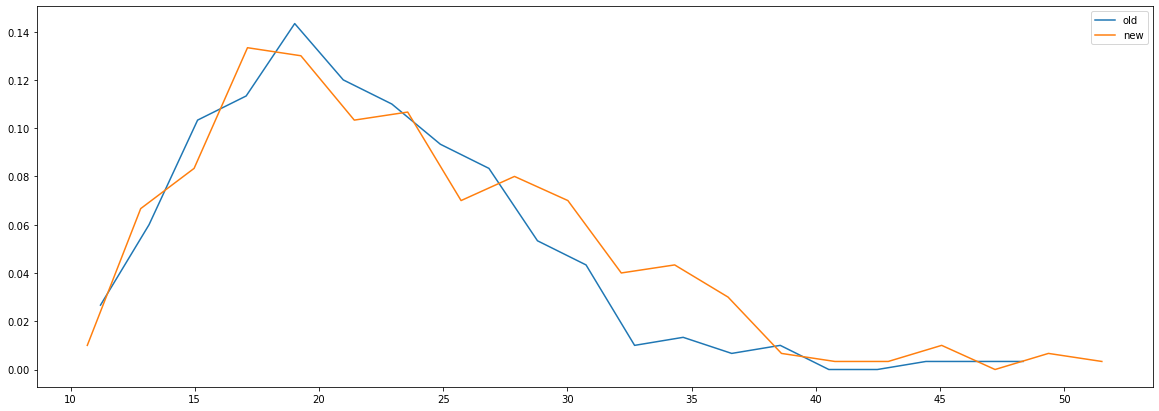

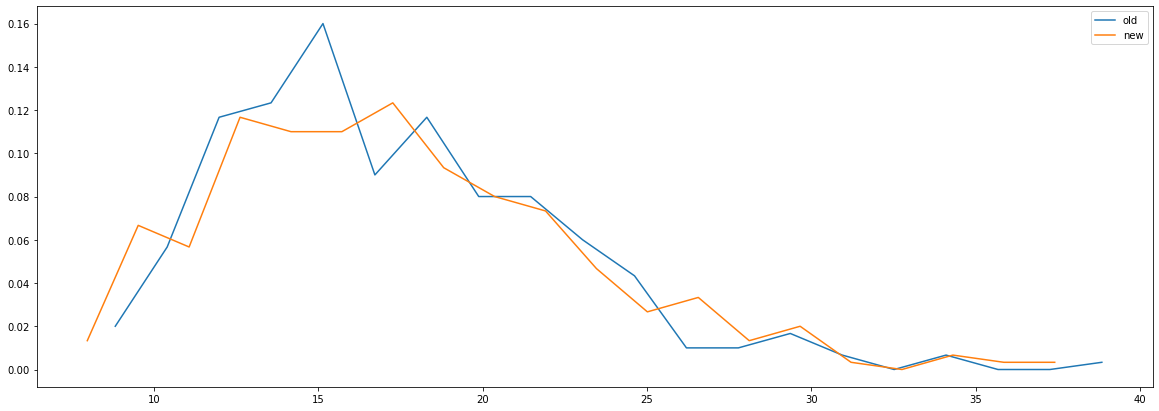

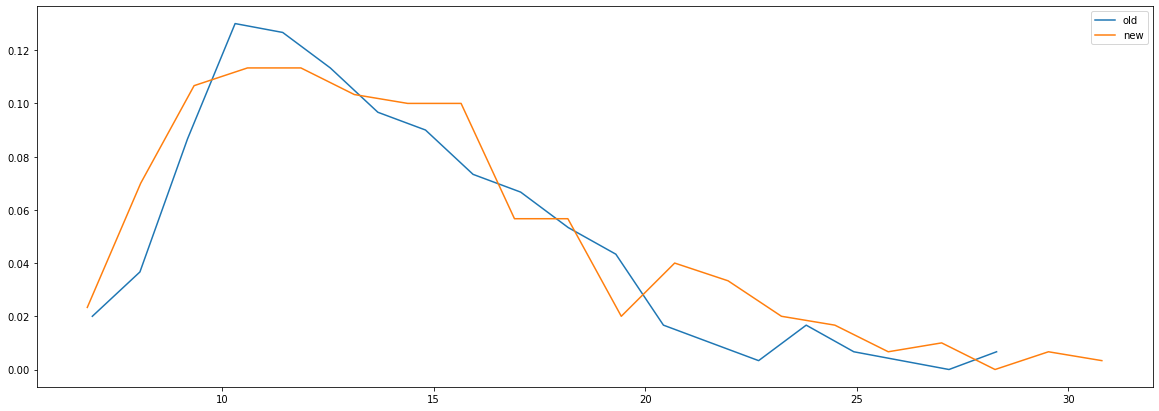

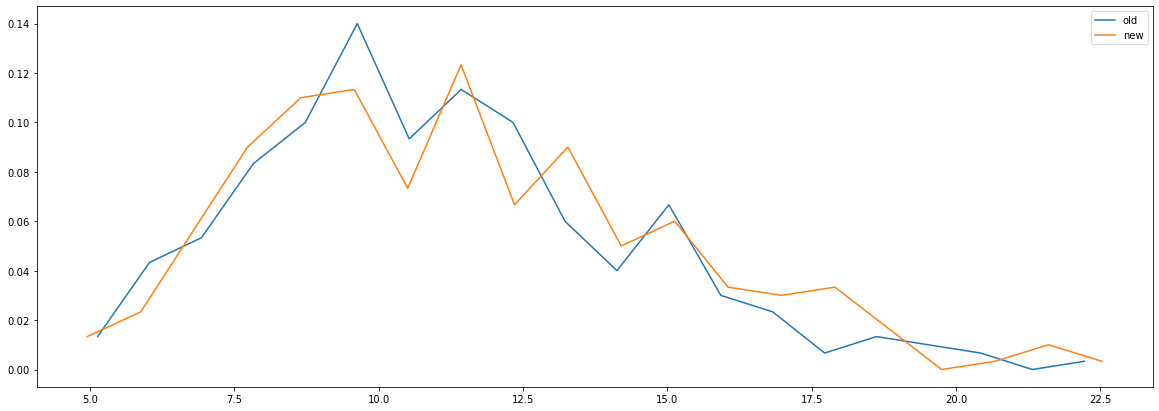

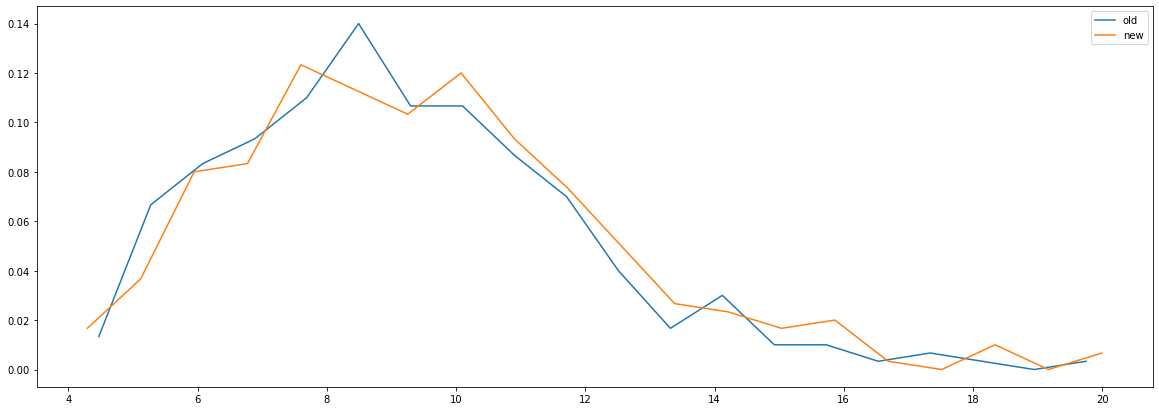

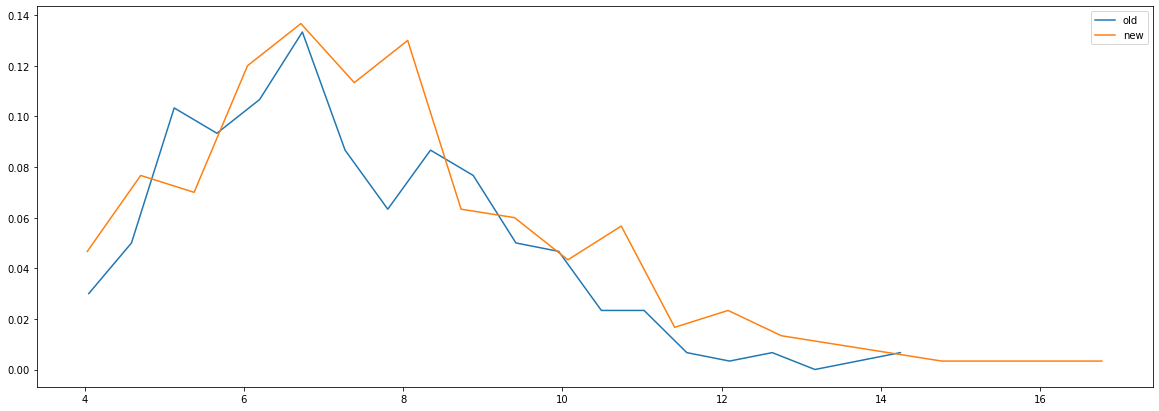

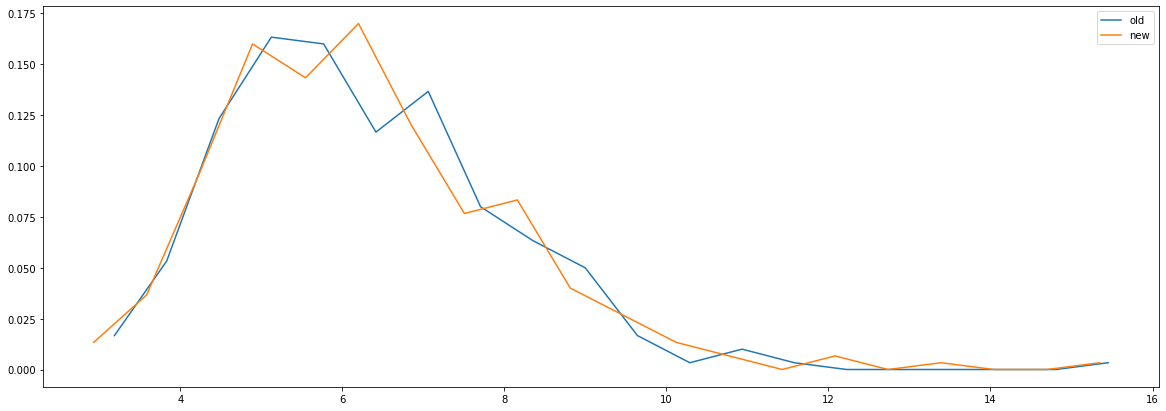

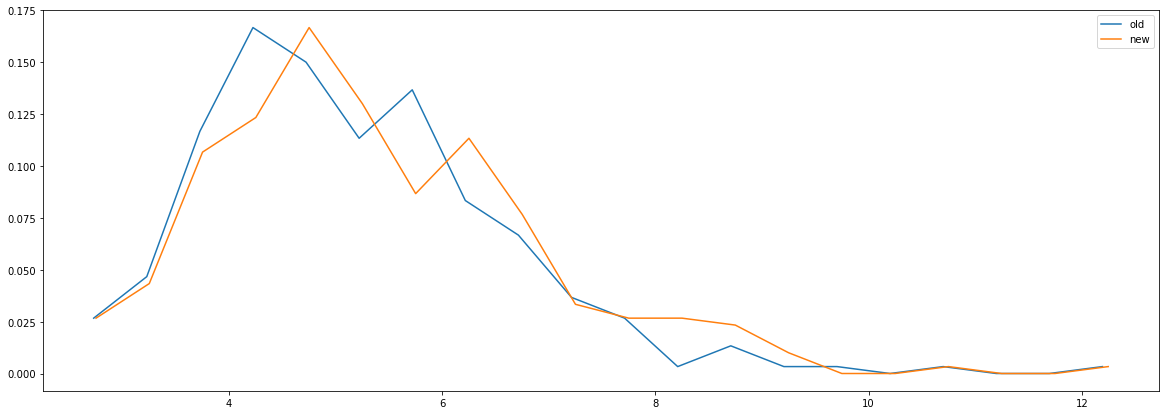

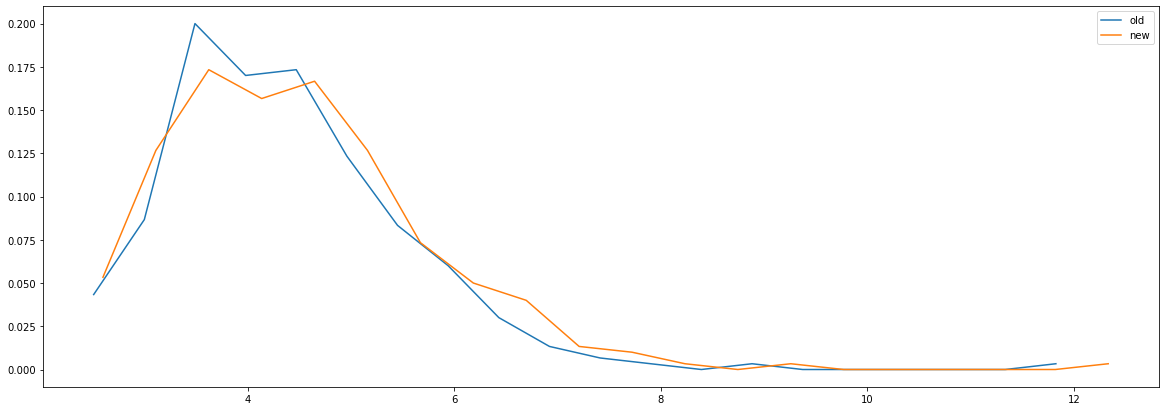

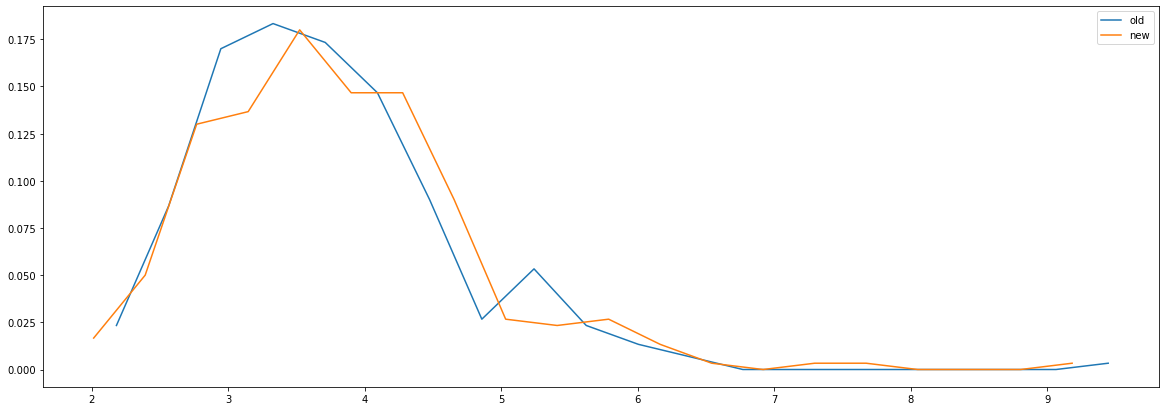

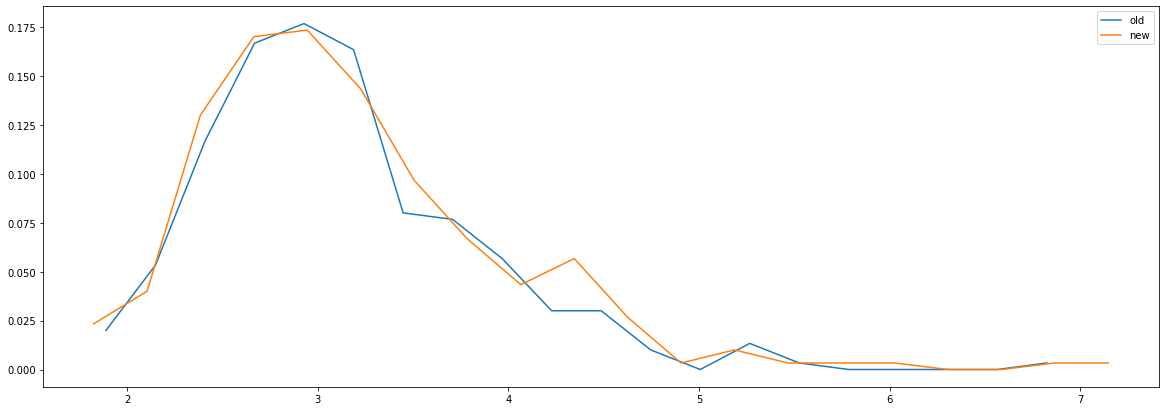

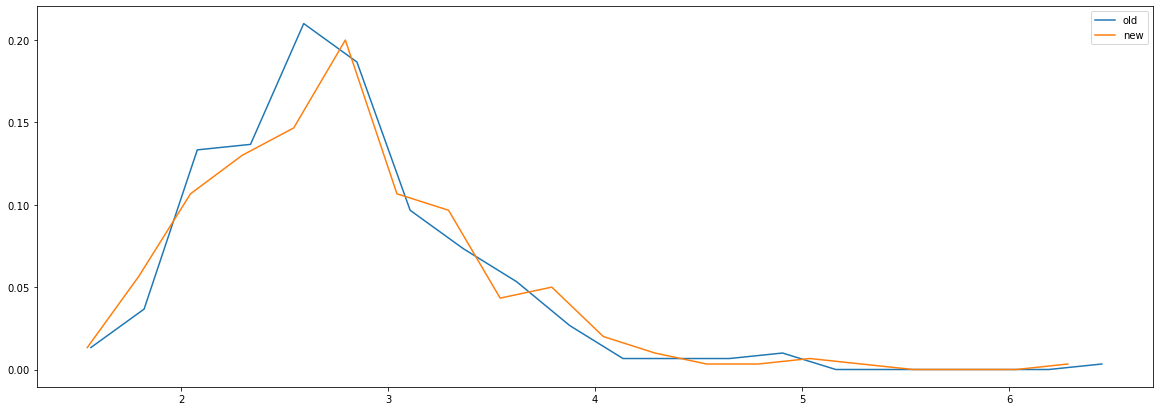

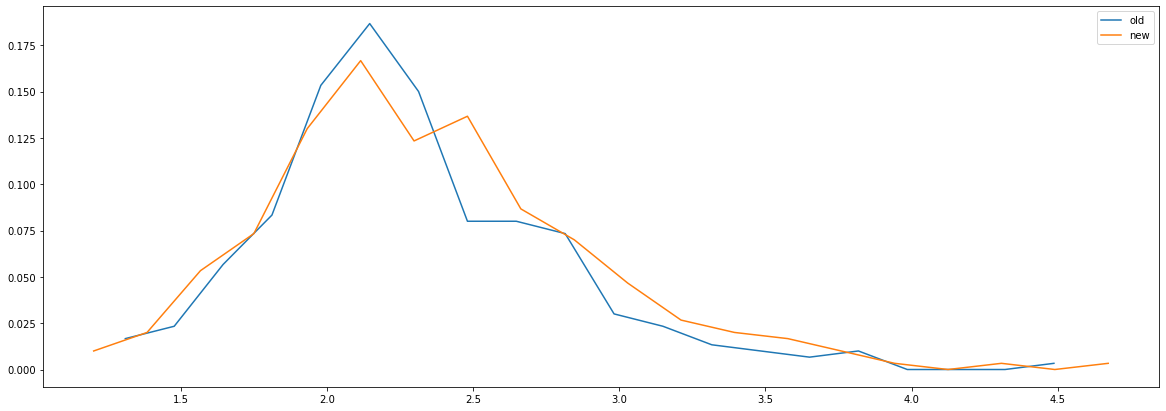

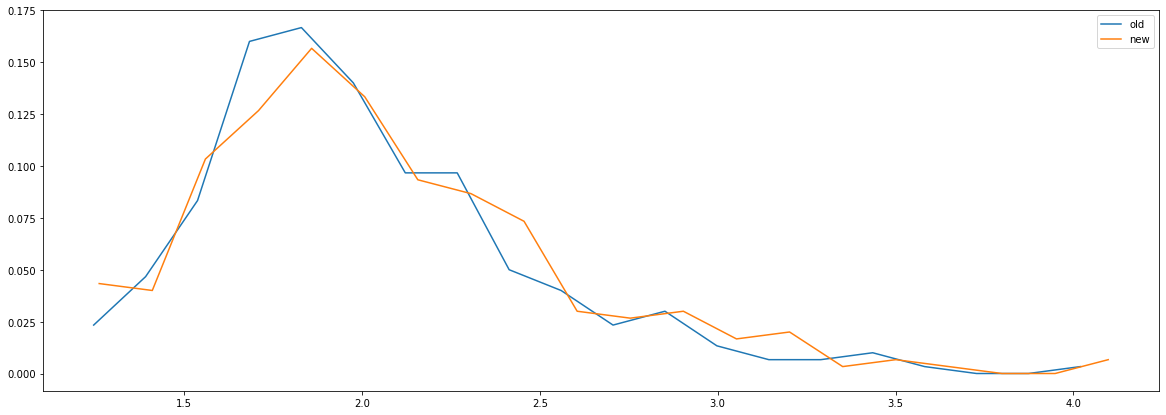

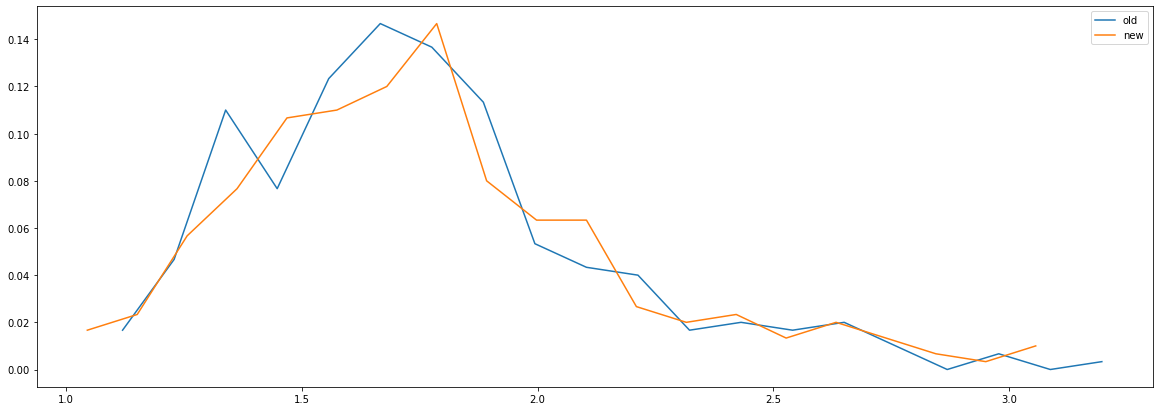

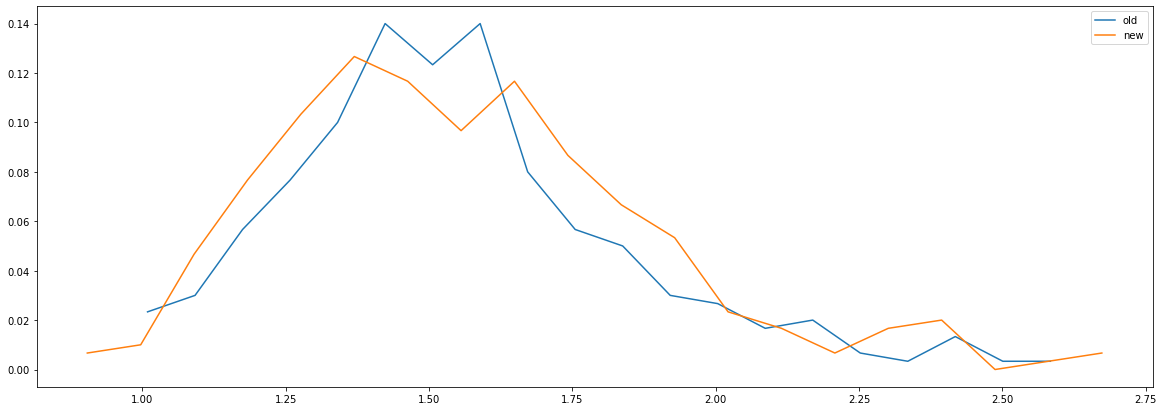

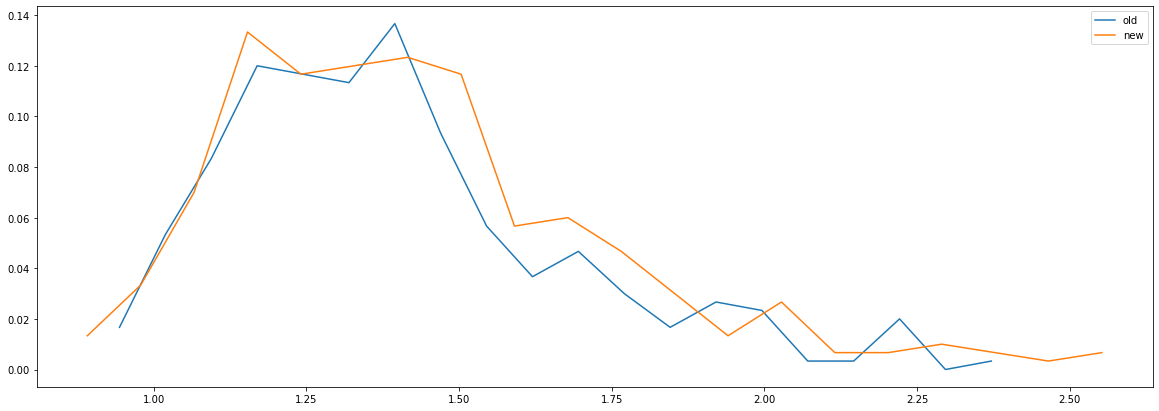

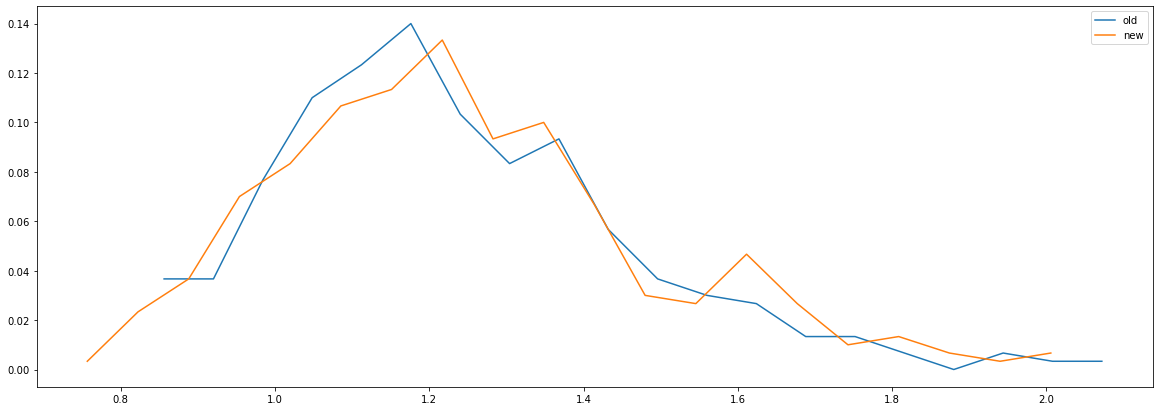

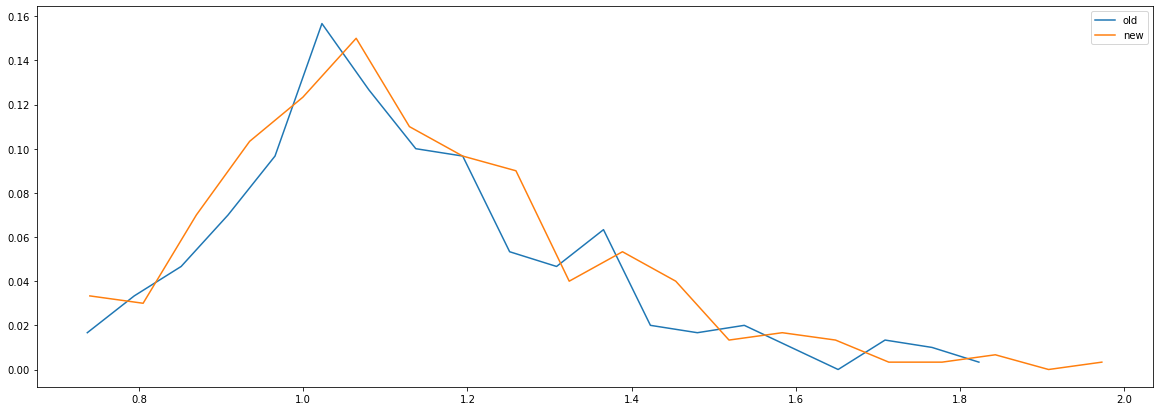

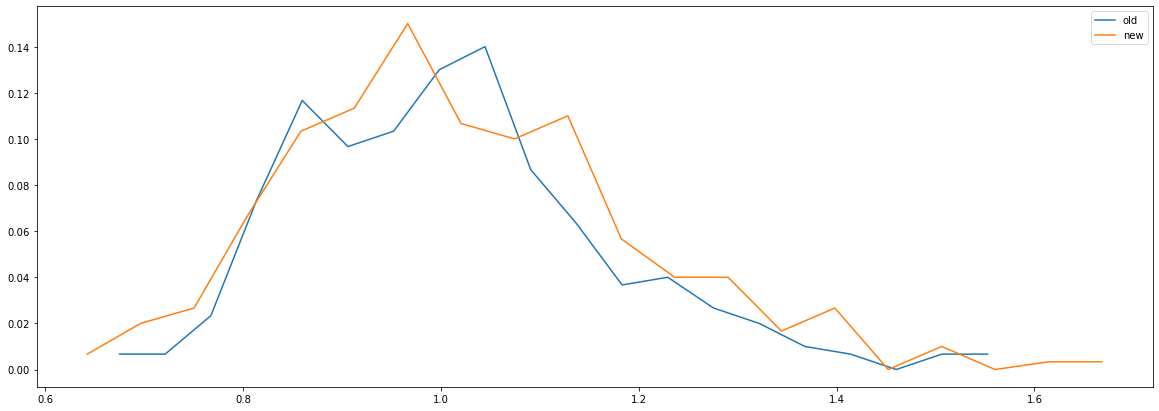

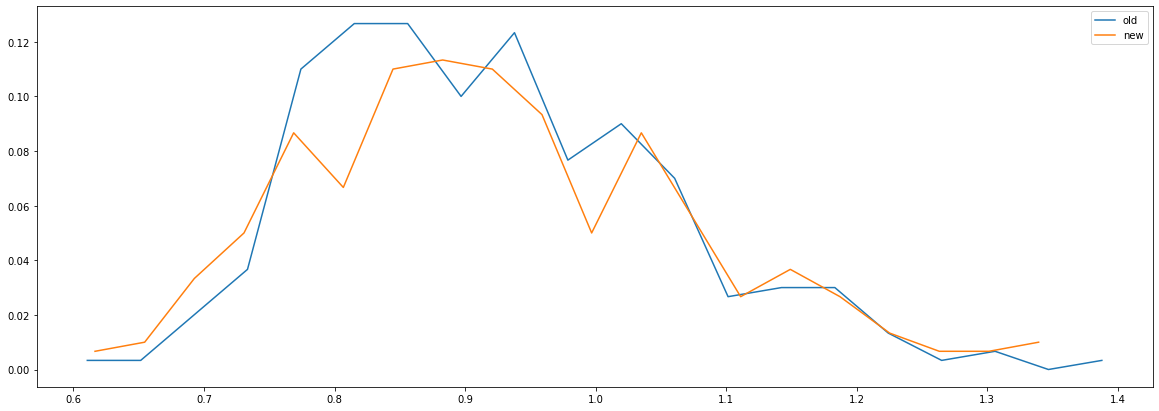

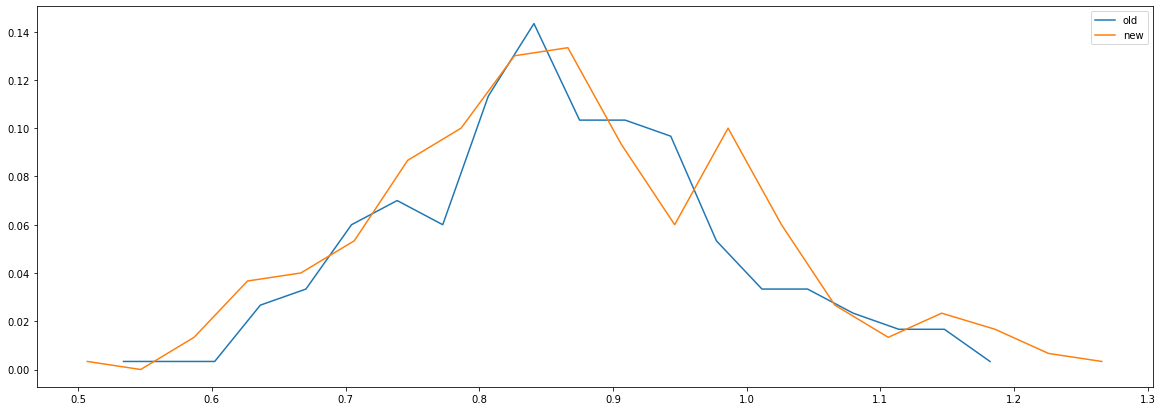

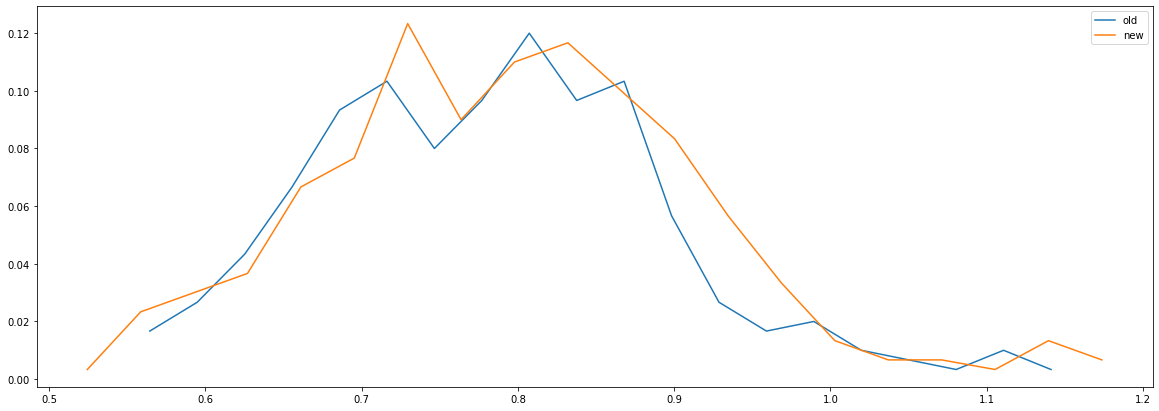

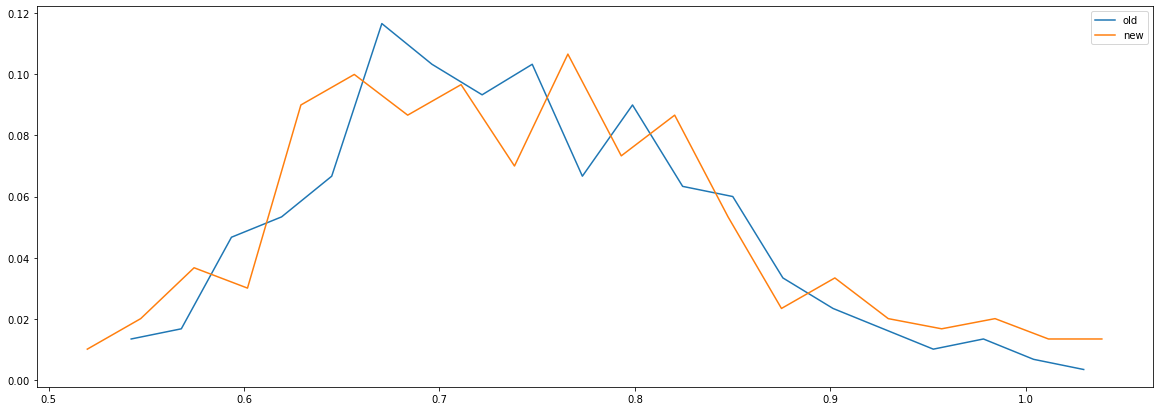

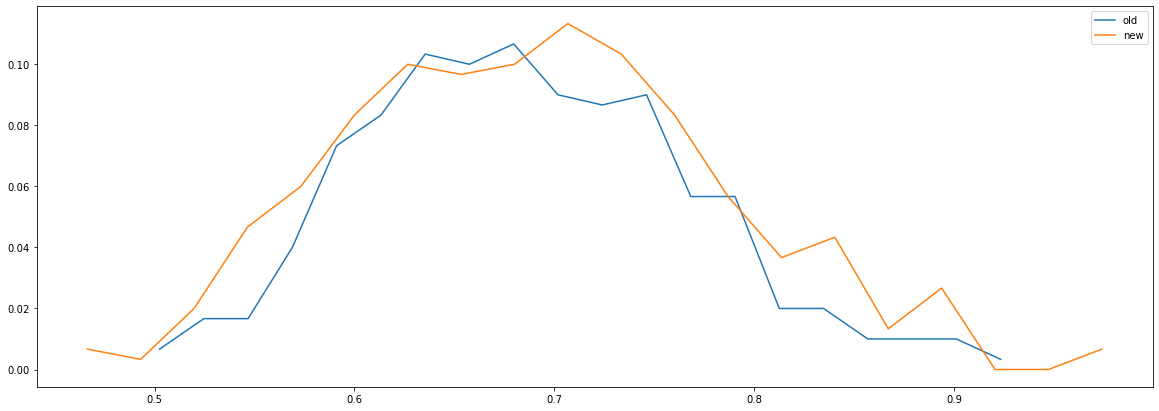

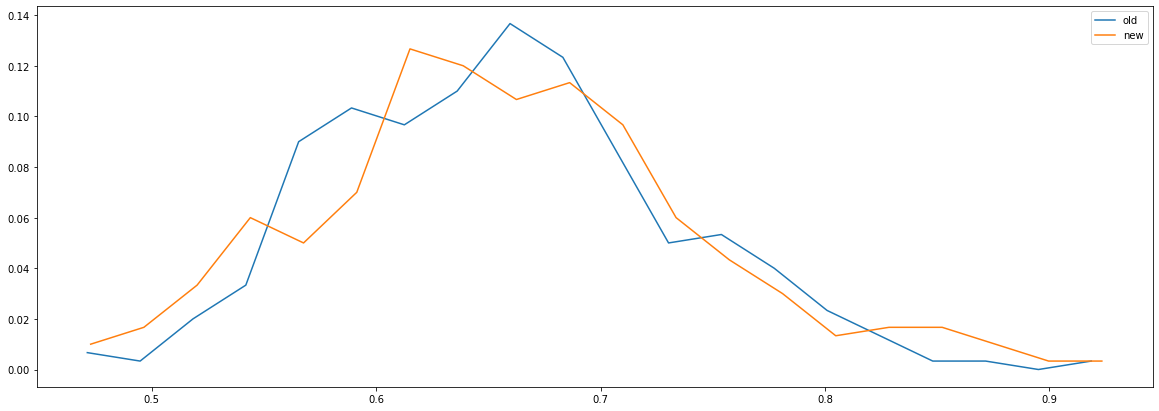

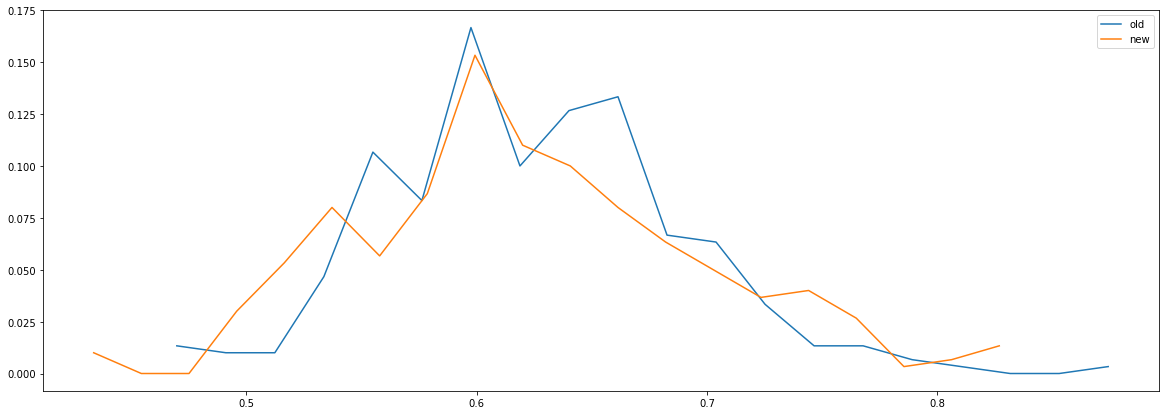

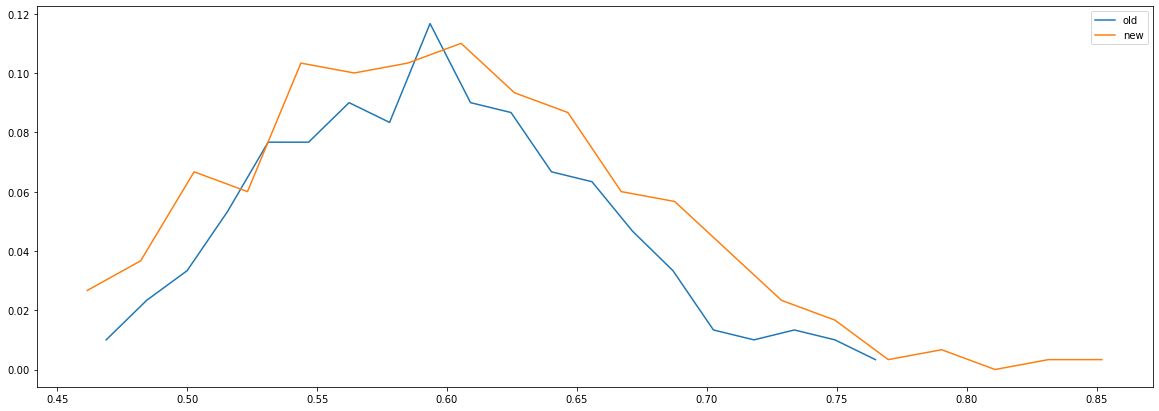

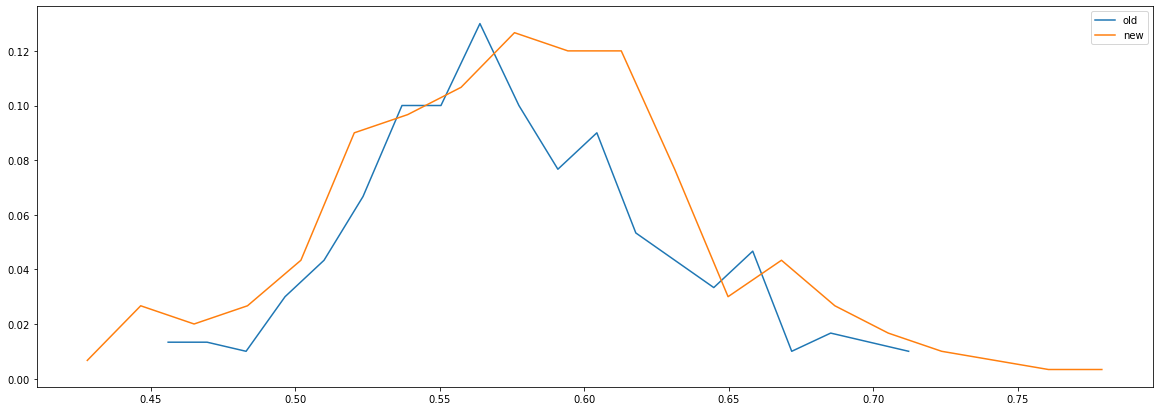

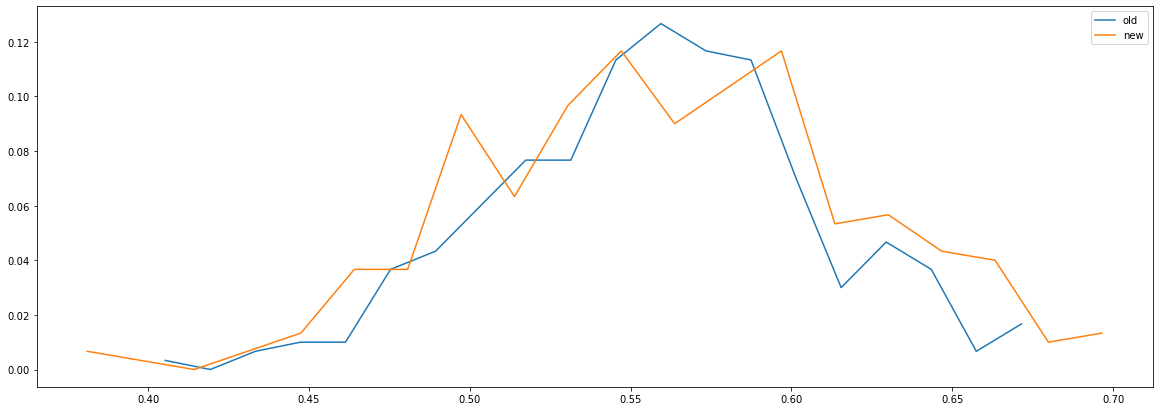

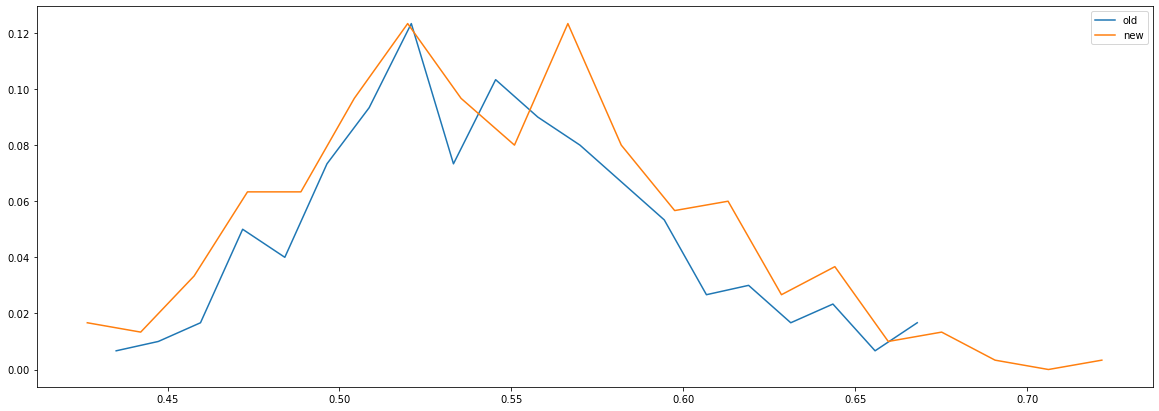

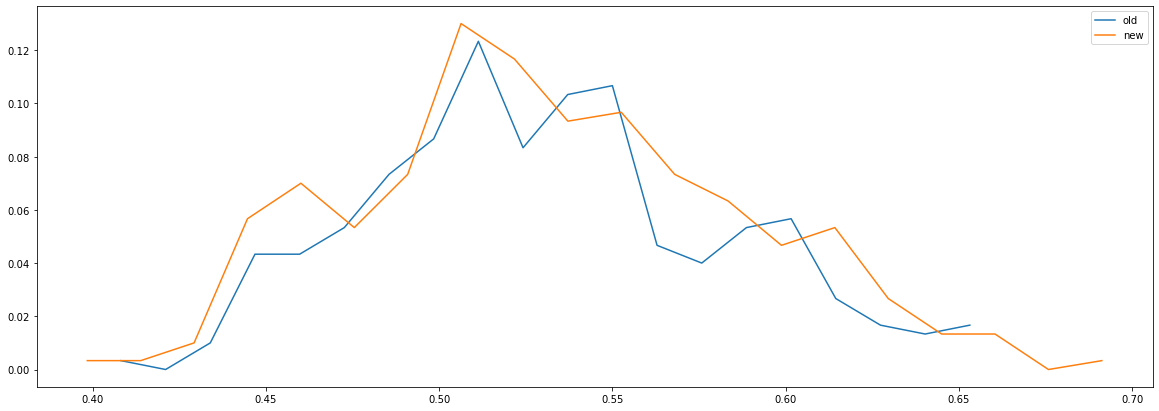

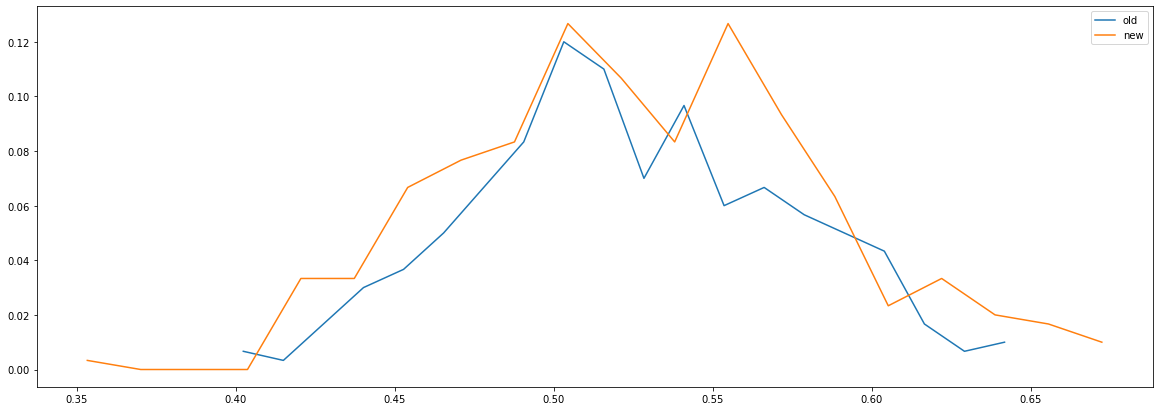

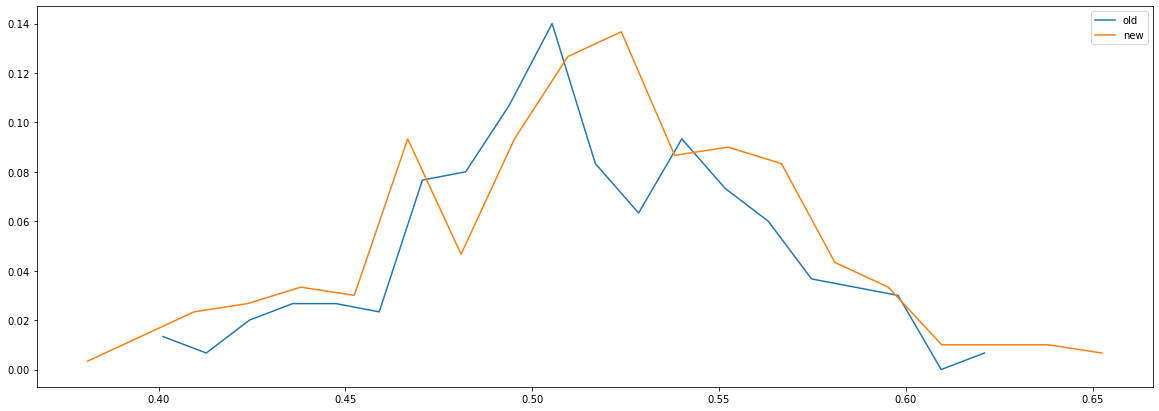

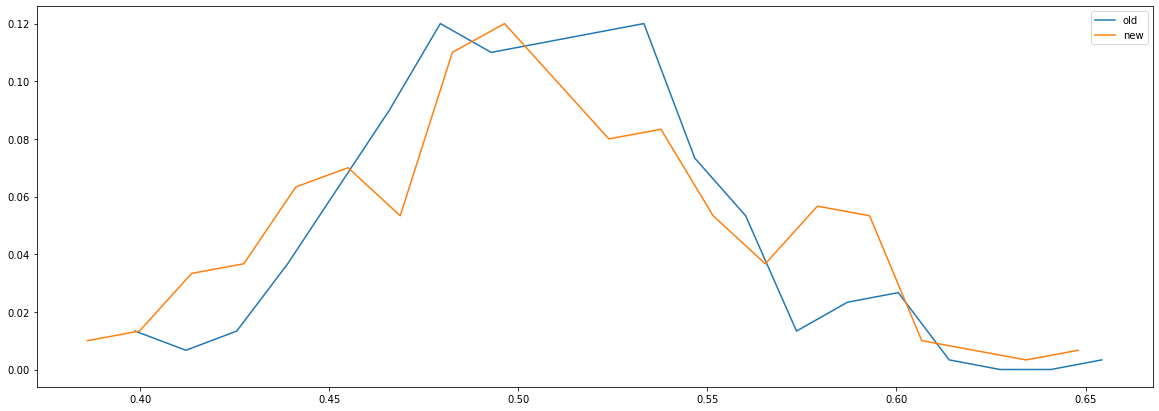

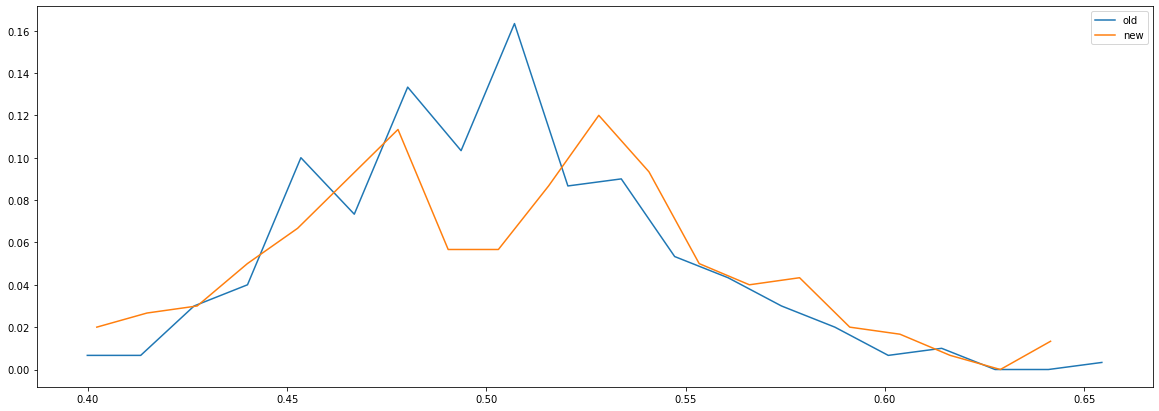

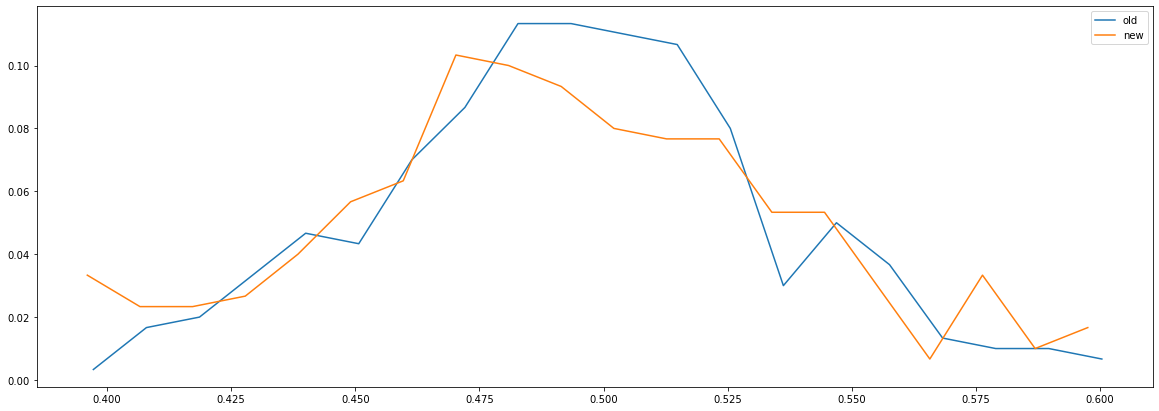

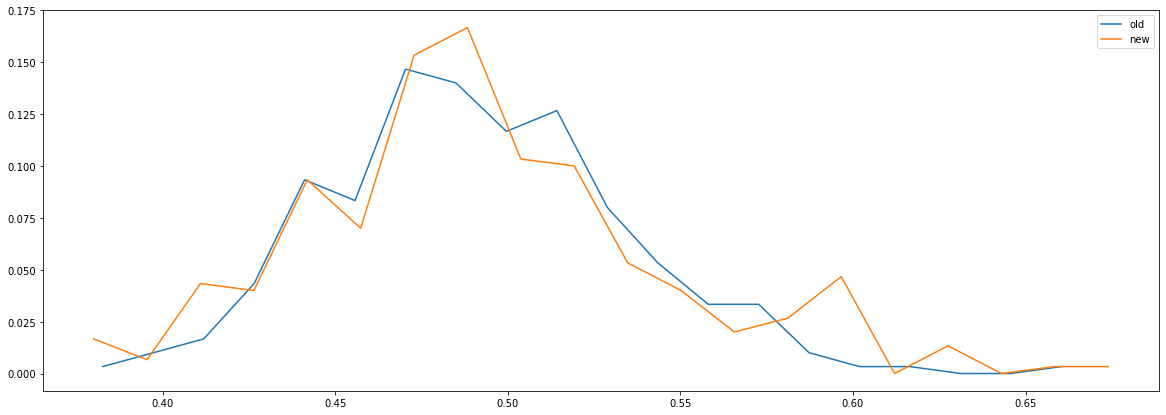

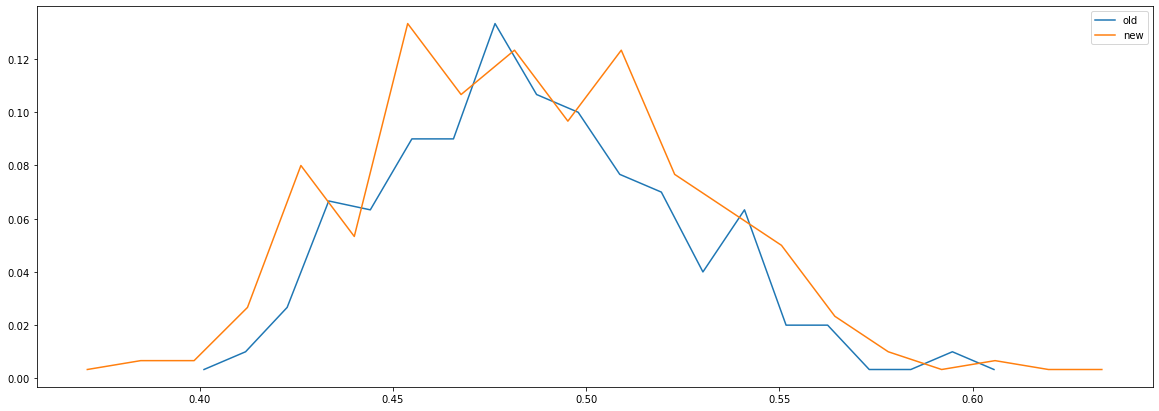

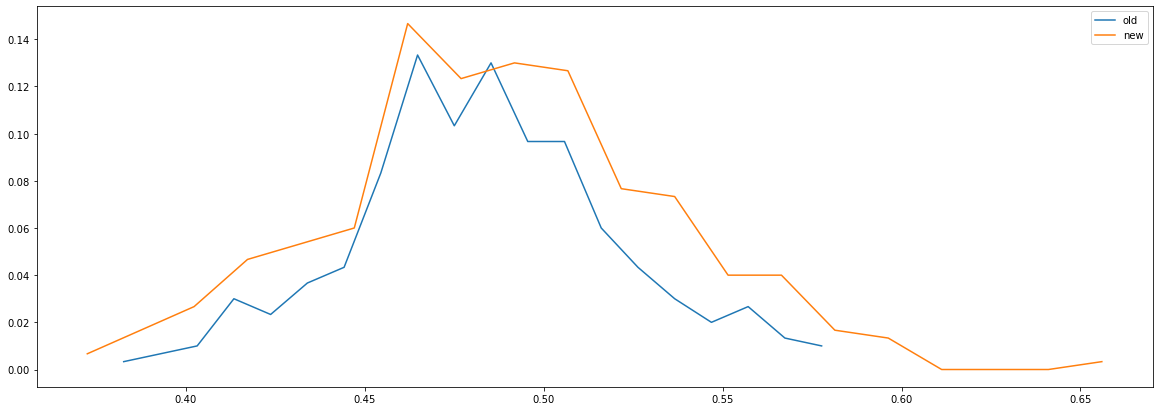

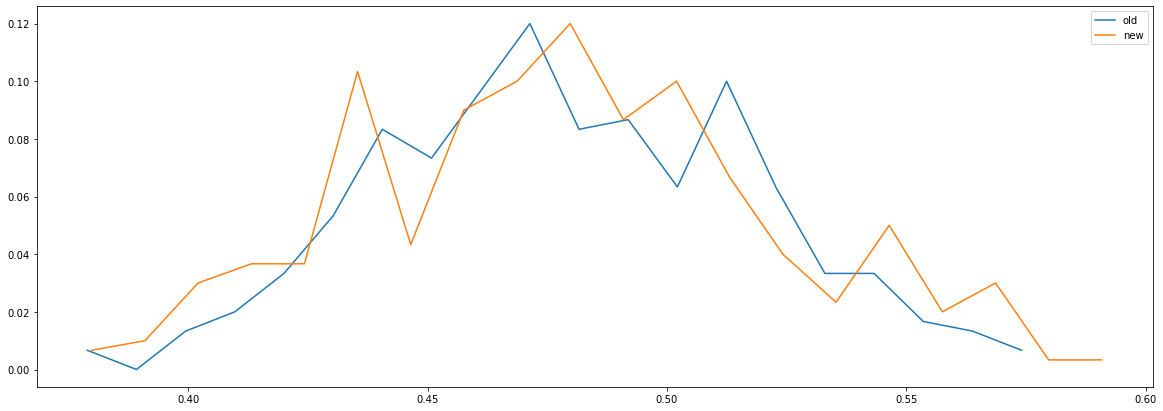

ValueError: autodetected range of [nan, nan] is not finite

In [1127]:
import scipy as sc

for i in range(4,50):

    data0,x0=np.histogram(RP_old[:,i],bins=20,density=True)
    data1,x1=np.histogram(RP_new[:,i],bins=20,density=True)


    plt.figure(figsize=(20,7))


    plt.plot(x0[1:],data0/data0.sum(),label='old')
    plt.plot(x1[1:],data1/data1.sum(),label='new')

    plt.legend()
    plt.show()

In [197]:
spectra=Anomalies_spectra[:,:,:51]
Gamma_scales=spectra.mean(axis=0)

0.75 0.875
26.58073083925105 37.72423156751041 48.99806386875817
19
8


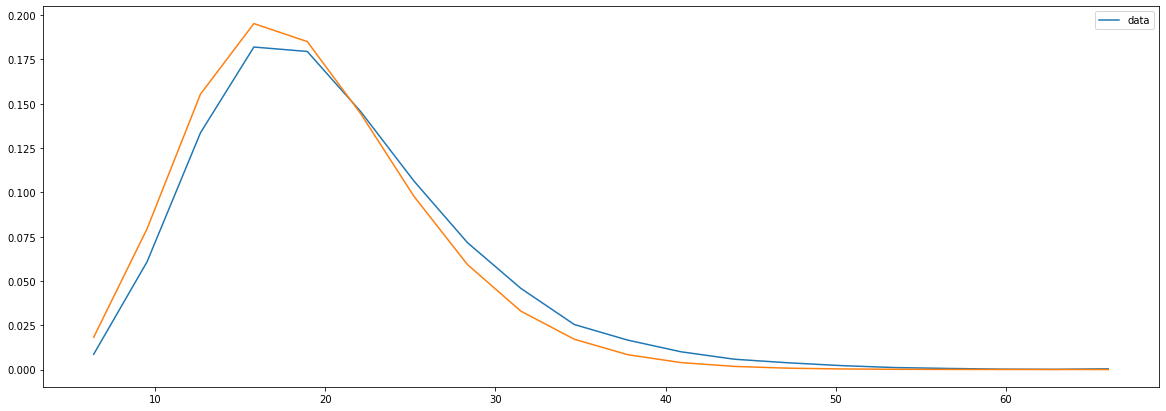

In [238]:
import scipy as sc
A_index0=21
B_index0=3

i=7

k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

spectrum=np.array([((spectra[i])[mask]/Gamma_scales[mask]).sum() for i in range(len(spectra))])

print(Gamma_scales[mask].min(),Gamma_scales[mask].mean(),Gamma_scales[mask].max())

data0,x0=np.histogram(spectrum,bins=20,density=True)

distr_shape=Spectral_dof[mask].sum()/2

m=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=Gamma_scales[mask].mean())

shape=8

l=sc.stats.gamma.pdf(x0[1:],a=shape,loc=0,scale=spectrum.mean()/shape)

print(mask.sum())
print(shape)



plt.figure(figsize=(20,7))

#plt.plot(x0[1:],data0/sc.special.gamma(distr_shape),label='data b=2')
plt.plot(x0[1:],data0/data0.sum(),label='data')
#plt.plot(x0[1:],m/m.sum(),label='Gamma {:.2f}'.format(distr_shape))
plt.plot(x0[1:],l/l.sum())

plt.legend()

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
       2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
       2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
       3.    , 3.0625, 3.125 , 3.1875, 3.25  , 3.3125, 3.375 , 3.4375,
       3.5   , 3.5625, 3.625 , 3.6875, 3.75  , 3.8125, 3.875 , 3.9375,
       4.    , 4.0625, 4.125 , 4.1875, 4.25  , 4.3125, 4.375 , 4.4375,
       4.5   , 4.5625, 4.625 , 4.6875, 4.75  , 4.8125, 4.875 , 4.9375,
       5.    , 5.0625, 5.125 , 5.1875, 5.25  , 5.3125, 5.375 , 5.4375,
       5.5   , 5.5625, 5.625 , 5.6875, 5.75  , 5.8125, 5.875 , 5.9375,
       6.    , 6.0625, 6.125 , 6.1875])

51

1.75 1.875
5.646041180516748 7.415594031764348 10.09411824988366
22
7.333333333333333


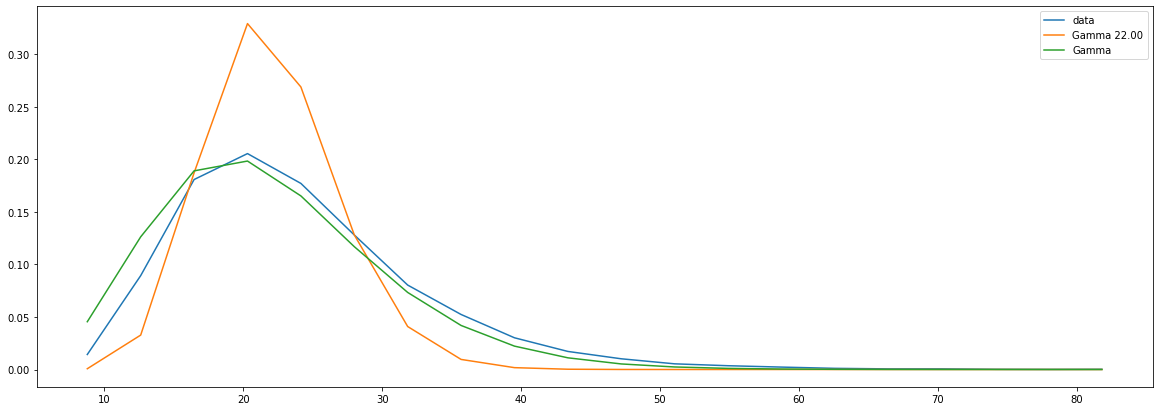

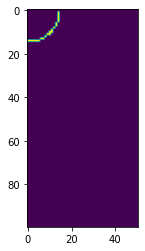

In [285]:
import scipy as sc
A_index0=21
B_index0=3

i=15

k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])&(ky>0)

spectrum=np.array([((spectra[i])[mask]/Gamma_scales[mask]).sum() for i in range(len(spectra))])

print(Gamma_scales[mask].min(),Gamma_scales[mask].mean(),Gamma_scales[mask].max())

data0,x0=np.histogram(spectrum,bins=20,density=True)

distr_shape=Spectral_dof[mask].sum()/2

m=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=1)

shape=distr_shape/3

l=sc.stats.gamma.pdf(x0[1:],a=shape,loc=0,scale=spectrum.mean()/shape)


plt.figure(figsize=(20,7))

#plt.plot(x0[1:],data0/sc.special.gamma(distr_shape),label='data b=2')
plt.plot(x0[1:],data0/data0.sum(),label='data')
plt.plot(x0[1:],m/m.sum(),label='Gamma {:.2f}'.format(distr_shape))
plt.plot(x0[1:],l/l.sum(),label='Gamma')

print(mask.sum())
print(shape)

plt.legend()
plt.show()
plt.imshow(mask)
plt.show()

4.9375 5.0
0.5100522022594565 0.5522196026058426 0.6044152183975706
27


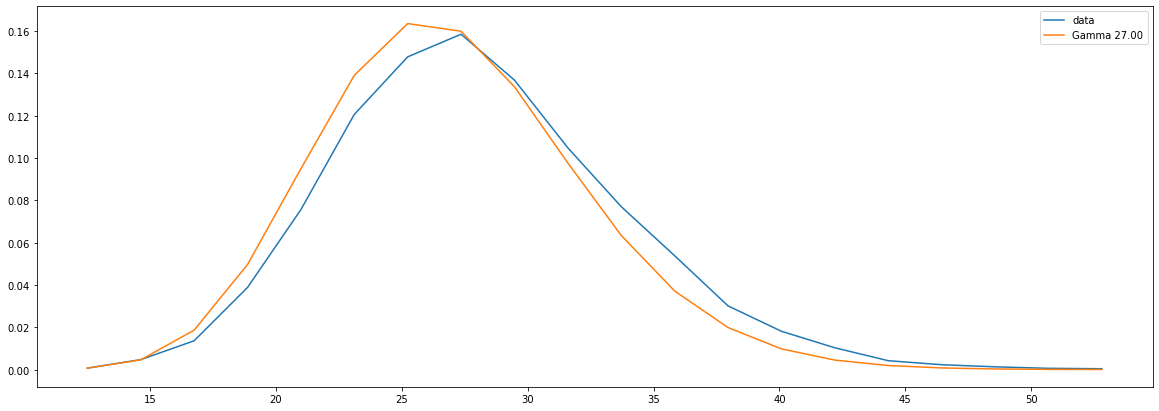

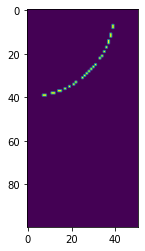

In [337]:
import scipy as sc
A_index0=21
B_index0=3

i=80

k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125/2)
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])&(ky>0)

spectrum=np.array([((spectra[i])[mask]/Gamma_scales[mask]).sum() for i in range(len(spectra))])

print(Gamma_scales[mask].min(),Gamma_scales[mask].mean(),Gamma_scales[mask].max())

data0,x0=np.histogram(spectrum,bins=20,density=True)

distr_shape=Spectral_dof[mask].sum()/2

m=sc.stats.gamma.pdf(x0[1:],a=distr_shape,loc=0,scale=1)

shape=distr_shape/3

l=sc.stats.gamma.pdf(x0[1:],a=shape,loc=0,scale=spectrum.mean()/shape)


plt.figure(figsize=(20,7))

#plt.plot(x0[1:],data0/sc.special.gamma(distr_shape),label='data b=2')
plt.plot(x0[1:],data0/data0.sum(),label='data')
plt.plot(x0[1:],m/m.sum(),label='Gamma {:.2f}'.format(distr_shape))
#plt.plot(x0[1:],l/l.sum(),label='Gamma')

print(mask.sum())
#print(shape)

plt.legend()
plt.show()
plt.imshow(mask)
plt.show()

In [322]:
k_values[8]

0.5

In [274]:
ky[:,0]

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [236]:
shape

13

In [186]:
dummy_anomalies.shape

(10000, 100, 100)

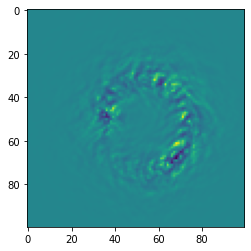

In [188]:
plt.imshow(dummy_anomalies[10])

In [189]:
dummy_anomalies.shape

(10000, 100, 100)

In [ ]:
Imag

In [138]:
k_values[4:]

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
       1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 , 2.375, 2.5  , 2.625,
       2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375, 3.5  , 3.625, 3.75 ,
       3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  , 4.625, 4.75 , 4.875,
       5.   , 5.125, 5.25 , 5.375, 5.5  , 5.625, 5.75 , 5.875, 6.   ,
       6.125, 6.25 ])

In [157]:
data0.sum()

0.6069954174001815

In [158]:
sc.special.gamma(distr_shape)

479001600.0

In [84]:
mask.sum()

5

2.125 2.25


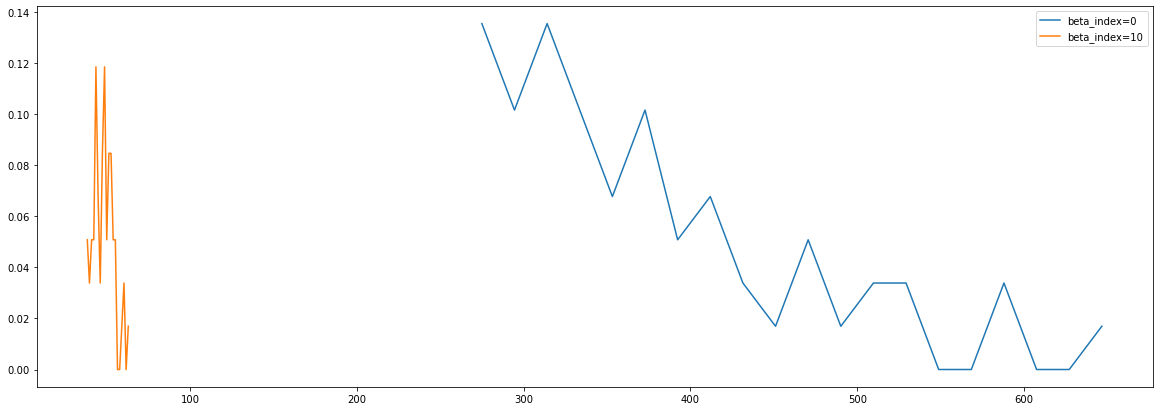

In [49]:
A_index0=31
B_index0=0

A_index1=0
B_index1=10

k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
i=18
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

indices=np.where(mask)

plt.figure(figsize=(20,7))

data,x=np.histogram(spectra32[A_index0,B_index0,:,mask].sum(axis=-1),bins=20,density=True)
norm_data=data/data.sum()
plt.plot(x[1:],norm_data,label='beta_index={:.0f}'.format(B_index0))

data,x=np.histogram(spectra80[A_index1,B_index1,:,mask].sum(axis=-1),bins=20,density=True)
norm_data=data/data.sum()
plt.plot(x[1:],norm_data,label='beta_index={:.0f}'.format(B_index1))
    
plt.legend()
plt.show()






In [ ]:
Ring_masks=np.zeros((length_radial_profile,image_shape[0],image_shape[1]))
for i in range(length_radial_profile):
    #Chose ring of given radius
    Ring_masks[i]=np.logical_and(R>=i,R<i+1)

In [152]:
y,x=np.indices(spectra32[-1,0,0].shape)

In [159]:
y=y-(spectra32[-1,0,0].shape[0]//2-0.5)

In [163]:
R=np.sqrt((y)**2+(x)**2).astype(int)

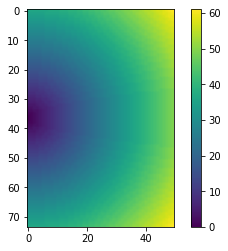

In [164]:
plt.imshow(R)
plt.colorbar()

In [170]:
length_radial_profile=np.minimum(*spectra32[-1,0,0].shape)//2

In [171]:
length_radial_profile

25

In [43]:
k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
Ring_masks=np.zeros((len(k_values),spectra32[-1,0,0].shape[0],spectra32[-1,0,0].shape[1]))
for i in range(1,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i]=np.logical_and(k_reduced_grid>=k_values[i-1],k_reduced_grid<k_values[i])

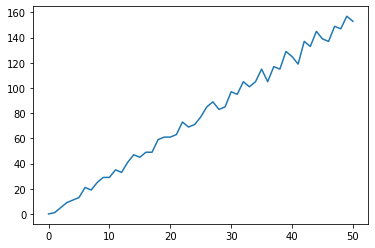

In [45]:
plt.plot(Ring_masks.sum(axis=(1,2)))

In [48]:
Ring_masks.sum(axis=(1,2))[2]

5.0

In [178]:
        GRF_params=[-7,4.7]
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Inference.Fourier_phase_tensor[1])

        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Inference.Fourier_phase_tensor[0,0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals=simulated_image-fit_image

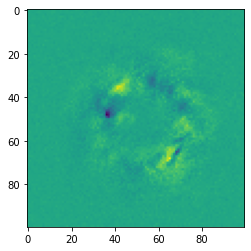

In [179]:
plt.imshow(residuals)

In [184]:
image=residuals
masked_image=image*Observation_conditions.annulus_mask
spectrum=jnp.abs(jnp.fft.fft2(masked_image))**2
normalized_spectrum=spectrum/Observation_conditions.annulus_mask.sum()

shift=Observation_conditions.annulus_mask.shape[0]//2
Centered_Spectrum=jnp.roll(normalized_spectrum,shift,axis=(0,1))

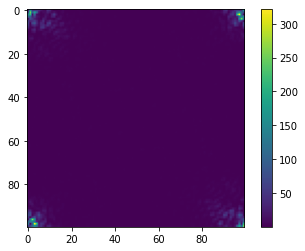

In [186]:
plt.imshow(spectrum)
plt.colorbar()

In [189]:
q=np.abs(np.fft.fft2(image*Observation_conditions.annulus_mask))**2

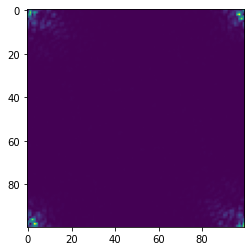

In [190]:
plt.imshow(q)

In [142]:
prof

DeviceArray([0.10669417, 0.2078213 , 0.33235072, 0.45986924, 0.57653238,
             0.6925974 , 0.81824041, 0.95118419, 1.07564676, 1.19473543,
             1.31991496, 1.4399279 , 1.5671144 , 1.69689135, 1.82082296,
             1.94930523, 2.07202013, 2.1919543 , 2.30985479, 2.43768908,
             2.57154099, 2.69773559, 2.81762479, 2.93773997, 3.06567033,
             3.19502025, 3.31638944, 3.44188251, 3.56792779, 3.68858505,
             3.81528683, 3.94361788, 4.07040672, 4.19583652, 4.31608129,
             4.43651011, 4.56107186, 4.691529  , 4.82005153, 4.94069911,
             5.06381041, 5.18892424, 5.31330614, 5.44060776, 5.56807181,
             5.69578766, 5.81883918, 5.93859092, 6.06481344, 6.1914262 ],            dtype=float64)

In [143]:
k_grid

array([[0.        , 0.125     , 0.25      , ..., 0.375     , 0.25      ,
        0.125     ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       ...,
       [0.375     , 0.39528471, 0.45069391, ..., 0.53033009, 0.45069391,
        0.39528471],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ]])

In [ ]:
A_index0=31
B_index0=0

k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
i=14
print(k_values[i-1],k_values[i])
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

indices=np.where(mask)

plt.figure(figsize=(20,7))

for i in range(len(indices[0])):
    data,x=np.histogram(spectra32[A_index0,B_index0,:,indices[0][i],indices[1][i]],bins=20,density=True)
    norm_data=data/data.sum()
    plt.plot(x[1:],norm_data,label='k_y={:.2f} k_x={:.2f}'.format(ky[indices[0][i],indices[1][i]],kx[indices[0][i],indices[1][i]]))
    

plt.show()





In [82]:
k_values=np.unique(np.abs(np.fft.fftfreq(100,0.08)))
mask=(k_reduced_grid>=k_values[i-1])&(k_reduced_grid<k_values[i])

In [86]:
k_x

NameError: name 'k_x' is not defined

In [84]:
k_values[i-1]

6.125

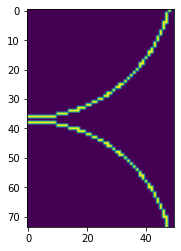

In [85]:
plt.imshow(mask)

(array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
         8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
        17, 17, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24,
        24, 25, 25, 26, 26, 27, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31,
        31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 38,
        38, 39, 39, 39, 39, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43,
        43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47,
        47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53,
        53, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57,
        57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 61, 61, 61, 61, 62,
        62, 

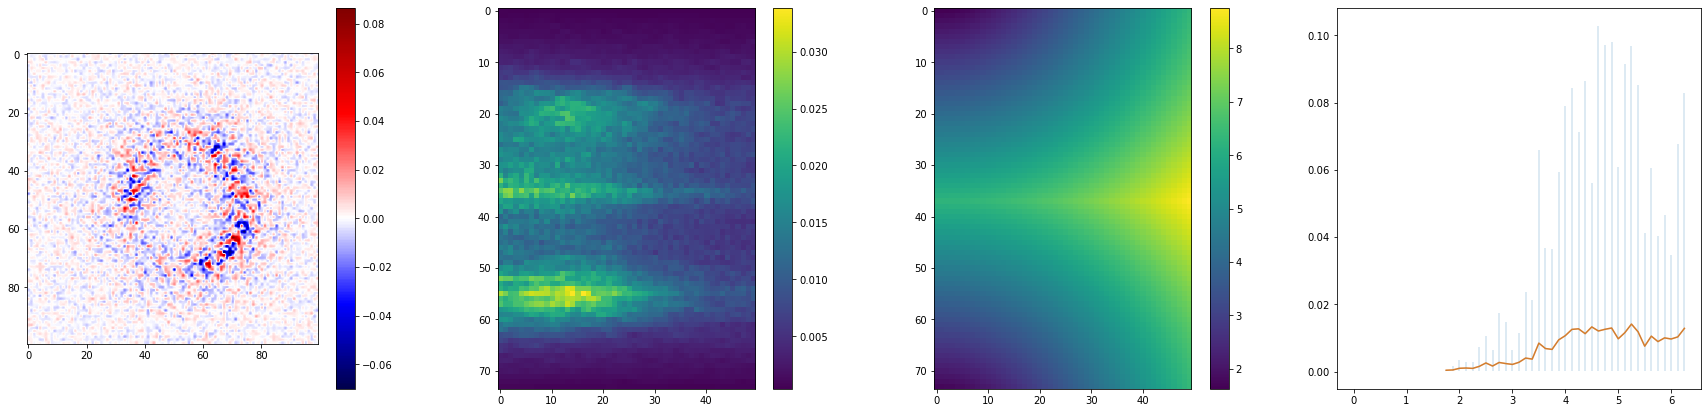

In [73]:
A_index0=10
B_index0=0
phi_index=0

fig,ax=plt.subplots(1,4,figsize=(30,7))

img=ax[0].imshow(Grid_batch[A_index0,B_index0,phi_index],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0])

img=ax[1].imshow(Gamma_scales[A_index0,B_index0])
fig.colorbar(img,ax=ax[1])
img=ax[2].imshow(k_grid[13:-13,:50])
fig.colorbar(img,ax=ax[2])

spectrum=spectra[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])
ax[3].errorbar(k_values,radial_spectrum,radial_errorbars,alpha=0.2)
ax[3].plot(k_values,radial_spectrum)


plt.show()

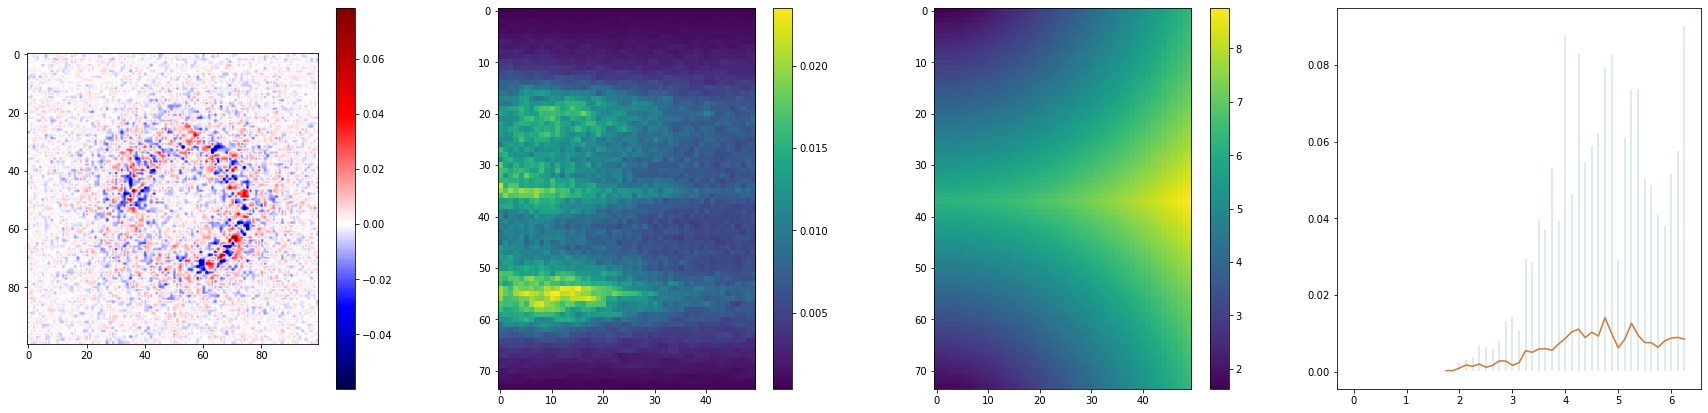

In [74]:
A_index0=10
B_index0=15
phi_index=0

fig,ax=plt.subplots(1,4,figsize=(30,7))

img=ax[0].imshow(Grid_batch[A_index0,B_index0,phi_index],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0])

img=ax[1].imshow(Gamma_scales[A_index0,B_index0])
fig.colorbar(img,ax=ax[1])
img=ax[2].imshow(k_grid[13:-13,:50])
fig.colorbar(img,ax=ax[2])

spectrum=spectra[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])
ax[3].errorbar(k_values,radial_spectrum,radial_errorbars,alpha=0.2)
ax[3].plot(k_values,radial_spectrum)


plt.show()

In [41]:
redud

array([0.        , 0.125     , 0.1767767 , ..., 8.66386173, 8.75089281,
       8.83883476])

In [247]:
k_values=np.fft.fftfreq(100,0.08)
k_reduced_grid=k_grid[13:-13,:50]



power0=(spectra[A_index0,B_index0]/Gamma_scales[A_index0,B_index0]).sum(axis=(-2,-1))

data0,x0=np.histogram(power0,bins=20,density=True)

norm_data0=data0/data0.sum()

k=500

m=sc.stats.gamma.pdf(x0[1:],a=k,loc=0,scale=power0.mean()/k)

plt.figure(figsize=(20,7))

plt.plot(x0[1:],norm_data0,label='data0')
plt.plot(x0[1:],n/n.sum(),label='Norm')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

In [246]:
get_k_grid??

In [260]:
GRF_params

[-7.725, 1.5543307086614173]

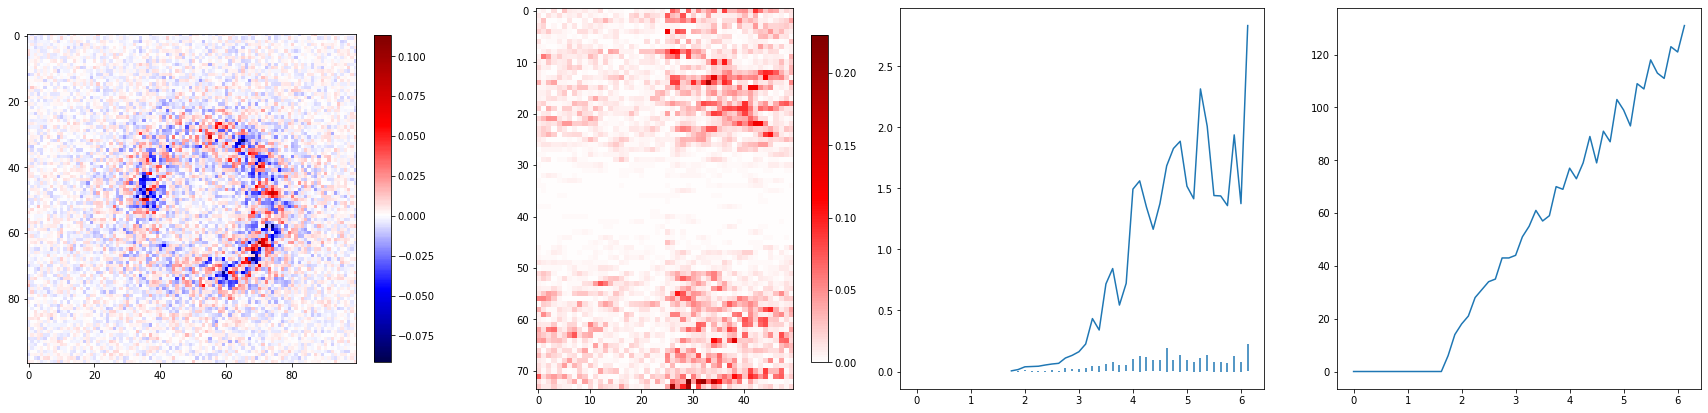

In [262]:
A_index0=30
B_index0=15
phi_index=0

spectrum=spectra[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=Grid_batch[A_index0,B_index0,phi_index]
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

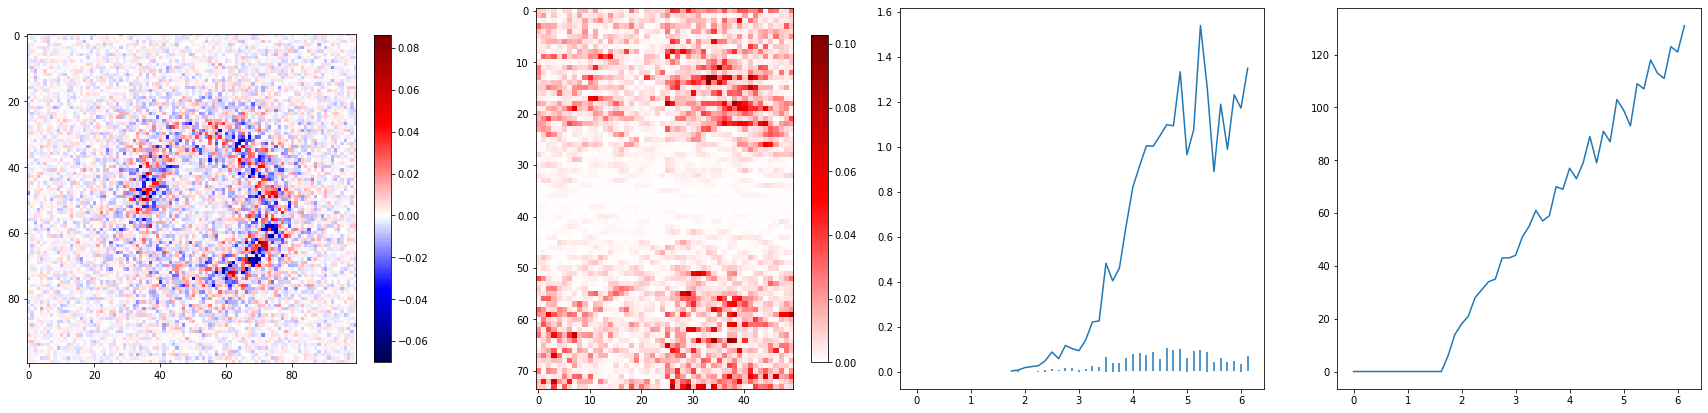

In [263]:
A_index0=10
B_index0=0
phi_index=0

spectrum=spectra[A_index0,B_index0,phi_index]

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=Grid_batch[A_index0,B_index0,phi_index]
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

In [266]:
q=sc.signal.correlate2d(Grid_batch[A_index0,B_index0,phi_index],Grid_batch[A_index0,B_index0,phi_index])

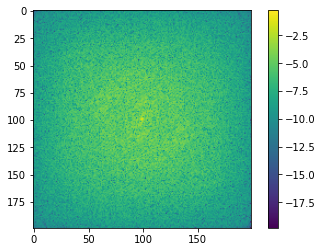

In [271]:
plt.imshow(np.log(np.abs(q)))
plt.colorbar()

In [268]:
q

array([[ 1.06921774e-08,  1.74355112e-06,  3.54209324e-06, ...,
         2.05119475e-06, -6.27052647e-06,  2.15967293e-06],
       [-5.65496036e-07,  7.99259379e-07,  1.23587898e-05, ...,
        -2.53446493e-05, -1.25481083e-05, -1.16961304e-05],
       [ 1.13808175e-06, -7.68253033e-06, -8.71812545e-06, ...,
         6.92153895e-06,  1.48101644e-05, -2.37757933e-06],
       ...,
       [-2.37757933e-06,  1.48101644e-05,  6.92153895e-06, ...,
        -8.71812545e-06, -7.68253033e-06,  1.13808175e-06],
       [-1.16961304e-05, -1.25481083e-05, -2.53446493e-05, ...,
         1.23587898e-05,  7.99259379e-07, -5.65496036e-07],
       [ 2.15967293e-06, -6.27052647e-06,  2.05119475e-06, ...,
         3.54209324e-06,  1.74355112e-06,  1.06921774e-08]])

In [315]:
        
        GRF_params=[-7,4.7]
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Inference.Fourier_phase_tensor[1])

        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Inference.Fourier_phase_tensor[0,0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals=simulated_image-fit_image

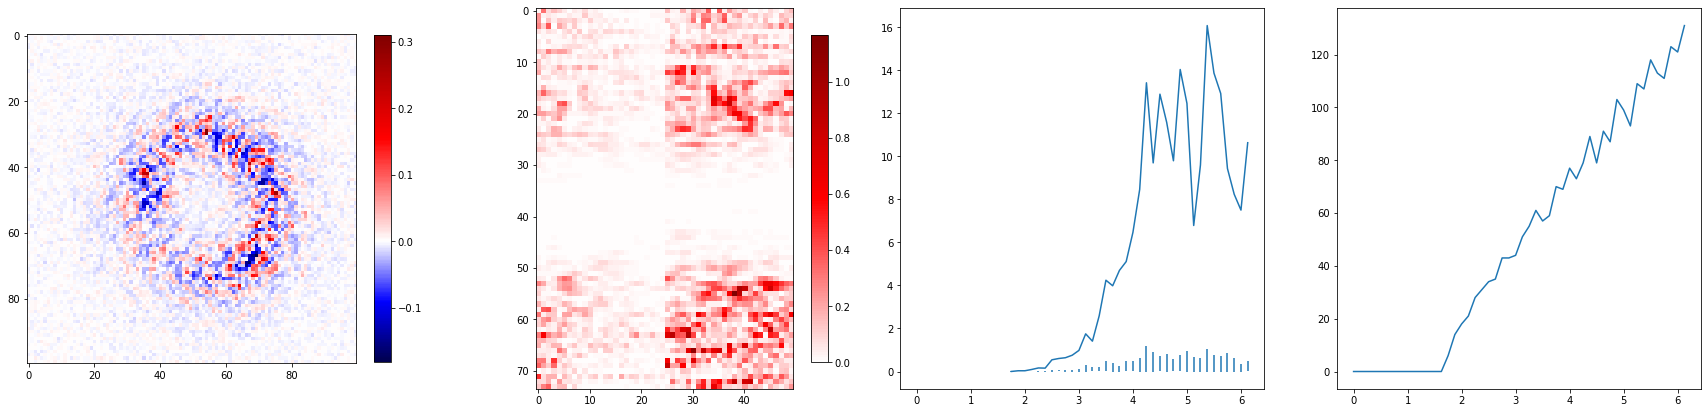

In [314]:
A_index0=10
B_index0=0
phi_index=60

spectrum=np.abs(np.fft.fft(residuals*Observation_conditions.annulus_mask)[13:-13,:50])**2

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=residuals
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

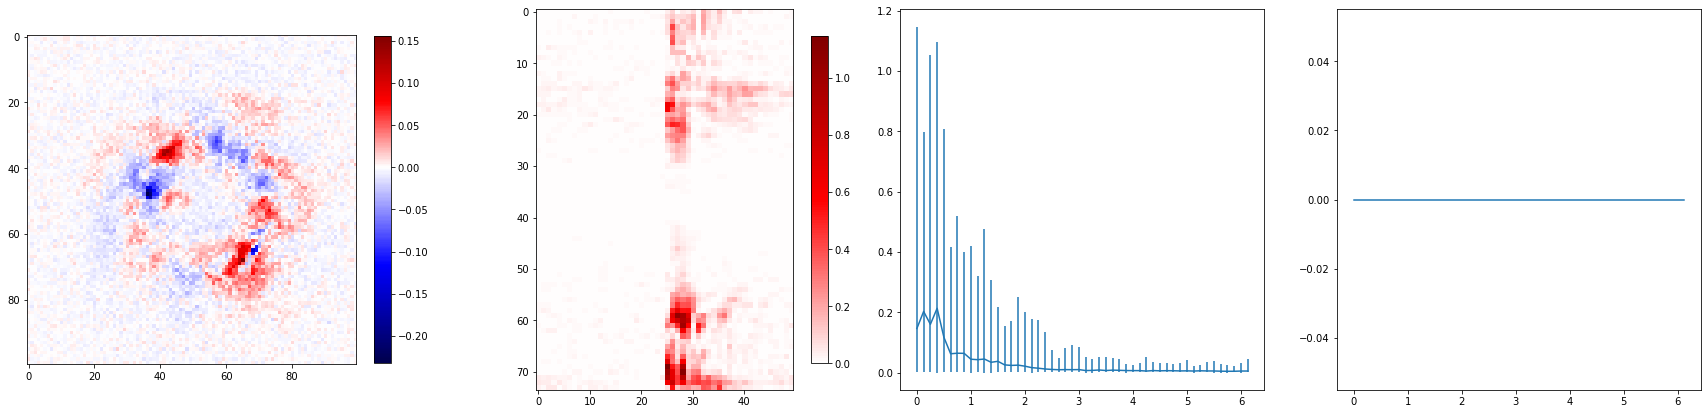

In [309]:
A_index0=10
B_index0=0
phi_index=60

spectrum=np.abs(np.fft.fft(residuals*Observation_conditions.annulus_mask)[13:-13,:50])**2

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radialx(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=residuals
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

In [301]:
radial_spectrum.sum()

0.878333174933297

In [316]:
        
        GRF_params=[-7,1.]
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Inference.Fourier_phase_tensor[1])

        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Inference.Fourier_phase_tensor[0,0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals=simulated_image-fit_image

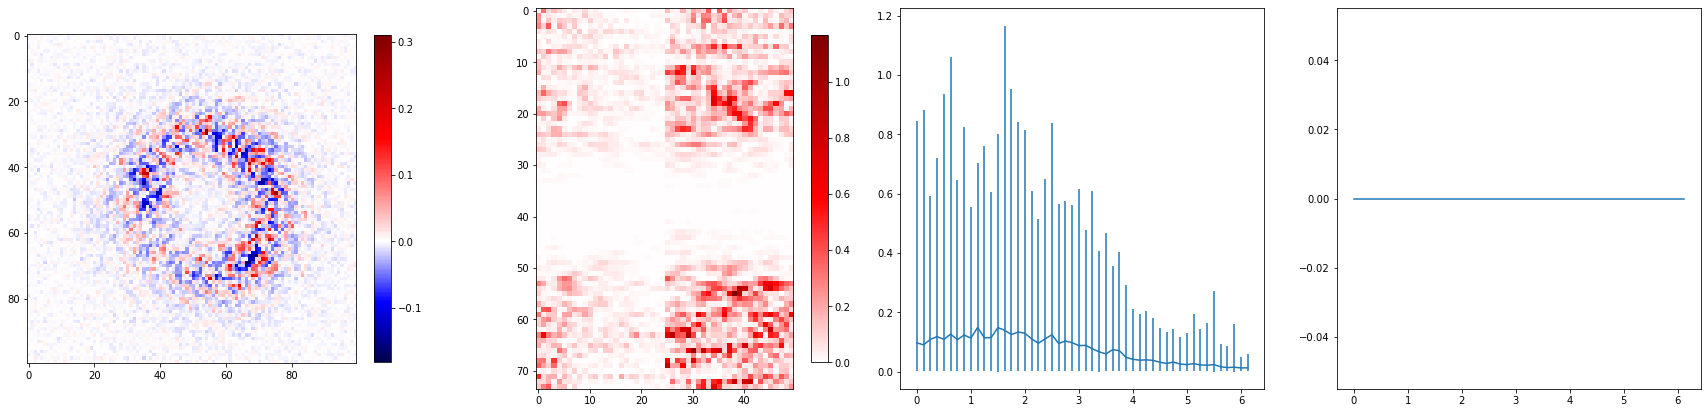

In [313]:
A_index0=10
B_index0=0
phi_index=0

spectrum=np.abs(np.fft.fft(residuals*Observation_conditions.annulus_mask)[13:-13,:50])**2

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radialx(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=residuals
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

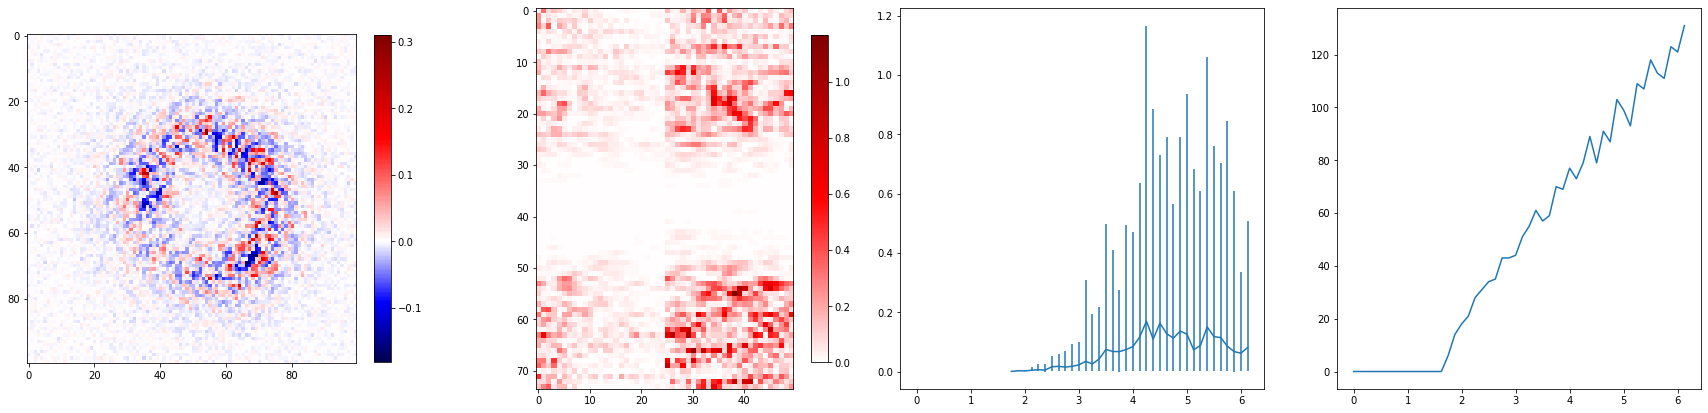

In [339]:
A_index0=10
B_index0=0
phi_index=0

spectrum=np.abs(np.fft.fft(residuals*Observation_conditions.annulus_mask)[13:-13,:50])**2

k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])

fig,ax=plt.subplots(1,4,figsize=(30,7))
image=residuals
spec=spectrum
img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[0],fraction=0.045)
img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=ax[1],fraction=0.045)
ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
ax[3].plot(k_values,counts)
plt.show()

In [372]:
        
        GRF_params=[-7,4.]
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Inference.Fourier_phase_tensor[0])

        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Inference.Fourier_phase_tensor[0,0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals=simulated_image-fit_image

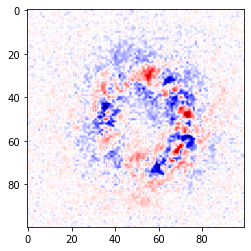

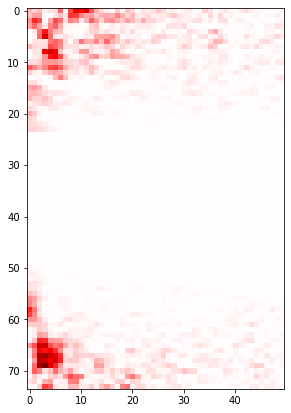

In [373]:
plt.imshow(residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

plt.figure(figsize=(15,7))
spectrum=np.abs(np.fft.fft(np.fft.fftshift(residuals*Observation_conditions.annulus_mask))[13:-13,:50])**2
plt.imshow(spectrum,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

In [387]:
from scipy.spatial import cKDTree

In [388]:
rng = np.random.default_rng()

In [389]:
points1 = rng.random((5, 2))

In [390]:
points1

array([[0.63538642, 0.39921333],
       [0.98671958, 0.16755342],
       [0.50201322, 0.17356961],
       [0.14332881, 0.73194027],
       [0.96133836, 0.82004886]])

In [391]:
from skimage.metrics import structural_similarity as ssim

In [395]:
        
        GRF_params=[-7,4.]
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Inference.Fourier_phase_tensor[1])

        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Inference.Fourier_phase_tensor[0,0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals_dif_scale=simulated_image-fit_image

In [396]:
ssim(residuals,residuals_dif_scale)

0.8289782763310936

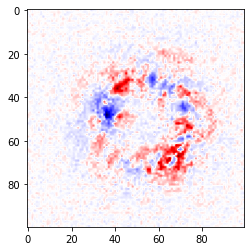

In [400]:
plt.imshow(residuals_dif_scale,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

In [374]:
def map_spec_to_radial(Spectrum,k_grid):
    
    k_values=np.arange(0,np.abs(np.fft.fftfreq(100,0.08)).max(),0.125)
    radial_spectrum=np.zeros_like(k_values)
    radial_errorbars=np.zeros((2,len(k_values)))
    counts=np.zeros_like(k_values)
    
    for i in range(1,len(k_values)):
        mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])
        counts[i]=mask.sum()
        if mask.sum()==0:
            radial_spectrum[i]=np.nan
            radial_errorbars[0,i]=np.nan
            radial_errorbars[1,i]=np.nan
            continue
        radial_spectrum[i]=Spectrum[mask].sum()
        radial_errorbars[0,i]=radial_spectrum[i]-Spectrum[mask].min()
        radial_errorbars[1,i]=Spectrum[mask].max()-radial_spectrum[i]
        
        
    return k_values,radial_spectrum,radial_errorbars,counts

In [375]:
k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spectrum,k_grid[13:-13,:50])

In [382]:
mask=(k_grid[13:-13,:50]>=k_values[25-1])&(k_grid[13:-13,:50]<k_values[25])

In [383]:
q=spectrum[mask]

In [384]:
q

array([0.0044655 , 0.04155134, 0.05554326, 0.01203269, 0.00735385,
       0.00587346, 0.02016155, 0.06693372, 0.03077628, 0.08732255,
       0.04655898, 0.01726967, 0.0171567 , 0.00732076, 0.01052967,
       0.02688128, 0.0279003 , 0.02202023, 0.01775191, 0.09281256,
       0.07005549, 0.04881703, 0.06999445, 0.10583589, 0.11382788,
       0.08985054, 0.00305363, 0.00983231, 0.05370076, 0.04857443,
       0.01153708, 0.00668689, 0.01430822, 0.02687469, 0.02129012,
       0.02009338, 0.02299819, 0.00250662, 0.00139873, 0.00070122,
       0.01500839, 0.02036522, 0.01229514, 0.00837402, 0.00149521,
       0.01379658, 0.02363532, 0.00475602, 0.05558367, 0.00621832,
       0.0066241 ])

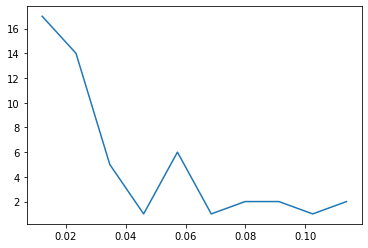

In [386]:
data,x=np.histogram(q,bins=10)
plt.plot(x[1:],data)

<ErrorbarContainer object of 3 artists>

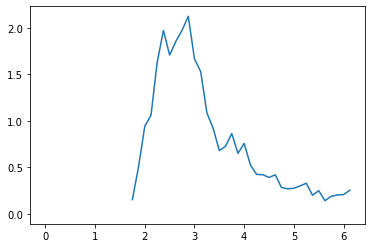

In [376]:
plt.errorbar(k_values,radial_spectrum)

<ErrorbarContainer object of 3 artists>

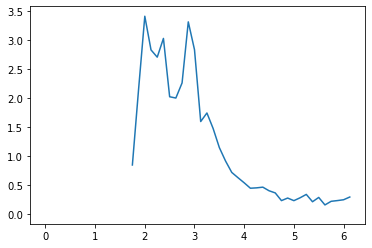

In [371]:
plt.errorbar(k_values,radial_spectrum)

<ErrorbarContainer object of 3 artists>

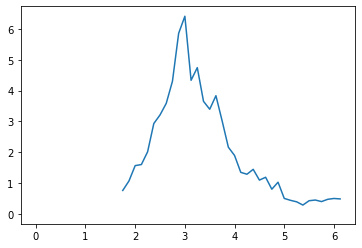

In [366]:
plt.errorbar(k_values,radial_spectrum)

<ErrorbarContainer object of 3 artists>

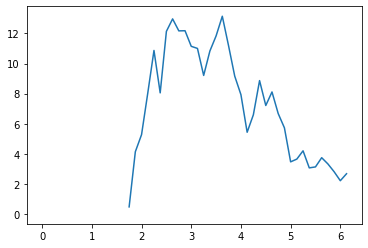

In [359]:
plt.errorbar(k_values,radial_spectrum)

In [351]:
1/3

0.3333333333333333

In [288]:
k_values

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
       3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375,
       4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375, 5.5  ,
       5.625, 5.75 , 5.875, 6.   , 6.125])

In [120]:
power_wrong.mean()

6036.9858188289

In [ ]:
power_wrong

In [69]:
np.arange(13,100-13,10)

array([13, 23, 33, 43, 53, 63, 73, 83])

array([13, 23, 33, 43, 53, 63, 73, 83])

In [30]:
def get_scale(Grid_batch):
    power_spectrum=np.abs(np.fft.fft(Grid_batch))**2
    Gamma_scale=spectrum.mean(axis=2)
    return Gamma_scale

In [31]:
Gamma_scale=get_scale(Grid_batch)

KeyboardInterrupt: 

In [28]:
logA_batch

array([-8.475, -8.45 , -8.425, -8.4  , -8.375, -8.35 , -8.325, -8.3  ,
       -8.275, -8.25 , -8.225, -8.2  , -8.175, -8.15 , -8.125, -8.1  ,
       -8.075, -8.05 , -8.025, -8.   , -7.975, -7.95 , -7.925, -7.9  ,
       -7.875, -7.85 , -7.825, -7.8  , -7.775, -7.75 , -7.725, -7.7  ])

In [29]:
Beta_batch

array([1.18425197, 1.22125984, 1.25826772, 1.29527559, 1.33228346,
       1.36929134, 1.40629921, 1.44330709, 1.48031496, 1.51732283,
       1.55433071, 1.59133858, 1.62834646, 1.66535433, 1.7023622 ,
       1.73937008])